# <u> Sentinel-2 Analysis Ready Data</u> <img align="right" src="../resources/csiro_easi_logo.png">
**Contents**
  - [Overview](#Overview)
  - [Notebook setup](#Notebook-setup)
  - [Dask computing environment](#Dask-computing-environment)
  - [Loading up the Sentinel-2 time series](#Loading-up-the-Sentinel-2-time-series)
    - [DataCube query](#DataCube-query)
    - [Quality layer](#Quality-layer)
  - [Spatial extents and time inputs](#Spatial-extents-and-time-inputs)
  - [Data query and load](#Data-query-and-load)
  - [Scaling factors](#Scaling-factors)
  - [Displaying results](#Displaying-results)
  - [Cloud masking](#Cloud_masking)
    - [Clear pixel mask](#Clear-pixel-mask)
    - [Valid pixel mask](#Valid-pixel-mask)
    - [Cloud masking and checking](#Cloud-masking-and-checking)
  -  [Creating a load ARD Sentinel-2 function](#Creating-a-load-ARD-Sentinel-2-function)
  -  [Data processing](#Data-processing)




# Overview

This notebook demonstrates how to create a time series of (mostly) cloud-free observations from Sentinel-2, and create a function to load Analysis Ready Data (ARD) which includes all routines to clean the data.

# Notebook setup

In this section, we import the relevant Python modules and functions needed in the rest of this notebook. We also define some input variables for the subsequent analysis.

## Importing modules and functions

In [1]:
import os, sys
os.environ['USE_PYGEOS'] = '0'

### Data tools
import numpy as np
import pandas as pd
import xarray as xr
import time


### Datacube
import datacube
from datacube.utils import masking
from datacube.model import Measurement
from datacube.utils import unsqueeze_dataset
from datacube.utils.geometry import CRS
from datacube.utils import geometry


## plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from odc.ui import with_ui_cbk
from odc.algo import to_f32, xr_geomedian, int_geomedian, enum_to_bool, mask_cleanup, erase_bad

## tools
repo = '/home/jovyan/easi-notebooks/easi-notebooks/'
if repo not in sys.path: sys.path.append(repo)
from easi_tools import EasiDefaults, notebook_utils
import easi_tools

repo = '/home/jovyan/cal-notebooks/scripts'
if repo not in sys.path: sys.path.append(repo)
from app_utils import display_map

# Holoviews, Datashader and Bokeh
import hvplot.pandas
import hvplot.xarray
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
# hv.extension('bokeh', logo=False)



# Dask computing environment

In EASI, each notebook starts by defining a Dask cluster for the notebook to use.


The are two main methods for setting up your dask cluster: 
1. **Local dask cluster**
    - Provides a dask multiprocessing environment on your Jupyter node. Useful for processing data volumes that don't exceed the Jupyter node limits, which are currently set at `cores = 8, memory = 32 GB` (2x large)


1. **Dask Gateway**
    - Provides a scalable compute cluster in EASI for your use. You can (*should*) use the same cluster across each of your notebooks (a separate cluster per notebook would unnessarily use EASI resources).
    - For most notebooks and data analysis start with `2 to 4 workers` (adaptive). Dask gateway is limited to 20 workers per user.
    - It is normal for this step to take **3 to 5 minutes** if new computing nodes need to be generated

**This notebook will just use a dask gateway cluster**



In [2]:
# Local cluster

# cluster = LocalCluster(n_workers=2, threads_per_worker=4)
# client = Client(cluster)
# display(client)
# dashboard_address = notebook_utils.localcluster_dashboard(client=client,server=easi.hub)
# display(dashboard_address)

# Remote cluster

# Dask gateway (separate worker machines)
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,10))
display(client)




Starting new cluster.


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.dfd0ff3ca8224869be8c2f254d9b2e68/status,


In [3]:
"""This function obtains credentials for S3 access and passes them on to
   processing threads, either local or on dask cluster.
   Note that AWS credentials may need to be renewed between sessions or
   after a period of time."""

from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

# If not using a dask cluster then remove 'client':
# configure_s3_access(aws_unsigned=False, requester_pays=True)

# Loading up the Sentinel-2 time series

## DataCube query

Before loading up the data we're interested in, let's connect to the DataCube database and query the Sentinel-2 measurements

In [4]:
# Load datacube

dc = datacube.Datacube()

# Load products and measurements, note offset is wrong

product = 's2_l2a'
product_measurements = dc.list_measurements().loc[product]
product_measurements

,name,dtype,units,nodata,aliases,flags_definition,add_offset,scale_factor
measurement,,,,,,,,
coastal,coastal,uint16,1,0.0,"[band_01, B01, coastal_aerosol]",NaN,-0.1,0.0001
blue,blue,uint16,1,0.0,"[band_02, B02]",NaN,-0.1,0.0001
green,green,uint16,1,0.0,"[band_03, B03]",NaN,-0.1,0.0001
red,red,uint16,1,0.0,"[band_04, B04]",NaN,-0.1,0.0001
rededge1,rededge1,uint16,1,0.0,"[band_05, B05, red_edge_1]",NaN,-0.1,0.0001
rededge2,rededge2,uint16,1,0.0,"[band_06, B06, red_edge_2]",NaN,-0.1,0.0001
rededge3,rededge3,uint16,1,0.0,"[band_07, B07, red_edge_3]",NaN,-0.1,0.0001
nir,nir,uint16,1,0.0,"[band_08, B08, nir_1]",NaN,-0.1,0.0001
nir08,nir08,uint16,1,0.0,"[band_8a, B8A, nir_2]",NaN,-0.1,0.0001


## Quality layer

To query the **SCL** layer we use functions that return this information in `pandas DataFrames`.

In [5]:
QA_layer = 'scl'
product_measurements.loc[QA_layer]['flags_definition']

{'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'no data',
   '1': 'saturated or defective',
   '2': 'dark area pixels',
   '3': 'cloud shadows',
   '4': 'vegetation',
   '5': 'bare soils',
   '6': 'water',
   '7': 'unclassified',
   '8': 'cloud medium probability',
   '9': 'cloud high probability',
   '10': 'thin cirrus',
   '11': 'snow or ice'},
  'description': 'Sen2Cor Scene Classification'}}

# Spatial extents and time inputs

When loading up the dataset, we select the time window of interest and geographic extent, in this case we get the UTM coordinate inputs. But most importantly, we can also apply our buffer `buffer_m` around the re-projected centre point (`x`, `y`). Earlier, we defined the buffer value in metres &ndash; this requires the centre point to be in projected coordinates.

In [6]:
# Time inputs
date_init = '2023-11-01'
date_end = '2024-03-31'

# convert the dates to UTC to make sure we get the data we want for Bangladesh time 
date_init_UTC = pd.to_datetime(date_init).tz_localize('Asia/Dhaka').tz_convert('UTC').tz_localize(None).strftime('%Y-%m-%d %H:%M:%S')
date_end_UTC = (pd.to_datetime(date_end) + pd.Timedelta(1, unit='D')).tz_localize('Asia/Dhaka').tz_convert('UTC').tz_localize(None).strftime('%Y-%m-%d %H:%M:%S')

date_init_UTC, date_end_UTC

('2023-10-31 18:00:00', '2024-03-31 18:00:00')

In [7]:
# Geographic inputs
# create a square of 1000 meters around a lat lon 
lat, lon = (22.85, 89.55)
buffer_m = 1000
# Convert buffer to degrees and get ranges
deg_per_meter_lat = 1 / 111320  # ~1 degree latitude per 111.32 km
deg_per_meter_lon = 1 / (np.cos(np.radians(lat)) * 111320)  # Adjust for latitude

lat_min = lat - buffer_m * deg_per_meter_lat
lat_max = lat + buffer_m * deg_per_meter_lat
lon_min = lon - buffer_m * deg_per_meter_lon
lon_max = lon + buffer_m * deg_per_meter_lon

lat_range = (lat_min, lat_max)
lon_range= (lon_min, lon_max)

# Get UTM geographic inputs
dst_crs = 'EPSG:32646' # Bangladesh CRS
lon_lat_point = geometry.point(lon, lat, CRS('WGS84'))
x, y = lon_lat_point.to_crs(dst_crs).points[0]
ul_coord = [y+buffer_m, x-buffer_m]
lr_coord = [y-buffer_m, x+buffer_m]
ul_coord, lr_coord

([2532058.2251166785, 144898.7960046347],
 [2530058.2251166785, 146898.7960046347])

In [8]:
# Display the map with bounding box
display_map(lon_range, lat_range)

We can then use these projected coordinates as input to our query including the dask chunks. 

# Data query and load

We create the DataCube query by selecting a square window around the point of interest. We also select the time window of interest, as well as the desired satellite bands.

In [9]:
# Dask parameters

dask_chunks = {"time": 10, "x": 100, "y": 100}  # https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes

# Query

query = {
        "time": (date_init, date_end),
        "x": (ul_coord[1], lr_coord[1]),  # (lon_west, lon_east) use the UTM coordinates
        "y": (ul_coord[0], lr_coord[0]),  # (lat_north, lat_south) use the UTM coordinates
        "product": 's2_l2a',
        "measurements": ["blue",
                         "green",
                         "red",
                         "nir08",
                         "swir16",
                         "swir22",
                         "SCL"],
        "resolution": (-30, 30),
        # "resolution": (-500, 500),
        "crs": dst_crs,
        "output_crs": dst_crs,
        "dask_chunks": dask_chunks,
        "group_by": "solar_day",
        # 'resampling': 'bilinear'
    }

# Load data

ds = dc.load(skip_broken_datasets=True, **query)
ds

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 35, y: 67, x: 68)
Coordinates:
  * time         (time) datetime64[ns] 280B 2023-11-02T04:42:18.657000 ... 20...
  * y            (y) float64 536B 2.532e+06 2.532e+06 ... 2.53e+06 2.53e+06
  * x            (x) float64 544B 1.449e+05 1.449e+05 ... 1.469e+05 1.469e+05
    spatial_ref  int32 4B 32646
Data variables:
    blue         (time, y, x) uint16 319kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    green        (time, y, x) uint16 319kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    red          (time, y, x) uint16 319kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    nir08        (time, y, x) uint16 319kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    swir16       (time, y, x) uint16 319kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    swir22       (time, y, x) uint16 319kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    SCL          (time, y, x) uint8 159kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
Attributes:
    crs:           EPSG:32646
    grid_mapping:  spatial_ref

# Scaling factors

To obtain the reflectance values, we apply the scaling factor and offset to the reflectance bands.

In [10]:
# Scaling factors for Sentinel-2 data
scale = 0.0001  # divide by 1000
offset = 0.0

# Apply the scale and offset factors to the Landsat data
# ds = to_f32(ds)
sr_bands = ["blue", "green", "red", "nir08", "swir16", "swir22"]

for band in sr_bands:
    ds[band] = scale * to_f32(ds[band]) + offset

ds

<xarray.Dataset> Size: 4MB
Dimensions:      (time: 35, y: 67, x: 68)
Coordinates:
  * time         (time) datetime64[ns] 280B 2023-11-02T04:42:18.657000 ... 20...
  * y            (y) float64 536B 2.532e+06 2.532e+06 ... 2.53e+06 2.53e+06
  * x            (x) float64 544B 1.449e+05 1.449e+05 ... 1.469e+05 1.469e+05
    spatial_ref  int32 4B 32646
Data variables:
    blue         (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    green        (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    red          (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    nir08        (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    swir16       (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    swir22       (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    SCL          (time, y, x) uint8 159kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
Attributes:
    crs:           EPSG:32646
    grid_mapping:  spatial_ref

In [11]:
# Checking that bands are in reflectance units using the red band

ds.red.max().compute(), ds.red.min().compute()  # Compute gets a value in local memory (it takes some time)

(<xarray.DataArray 'red' ()> Size: 4B
 array(1.6752, dtype=float32)
 Coordinates:
     spatial_ref  int32 4B 32646,
 <xarray.DataArray 'red' ()> Size: 4B
 array(1.e-04, dtype=float32)
 Coordinates:
     spatial_ref  int32 4B 32646)

# Displaying results

We can plot the result as a series of images using a false colour composite `swir22, nir08 and red`, one per time step.

/env/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


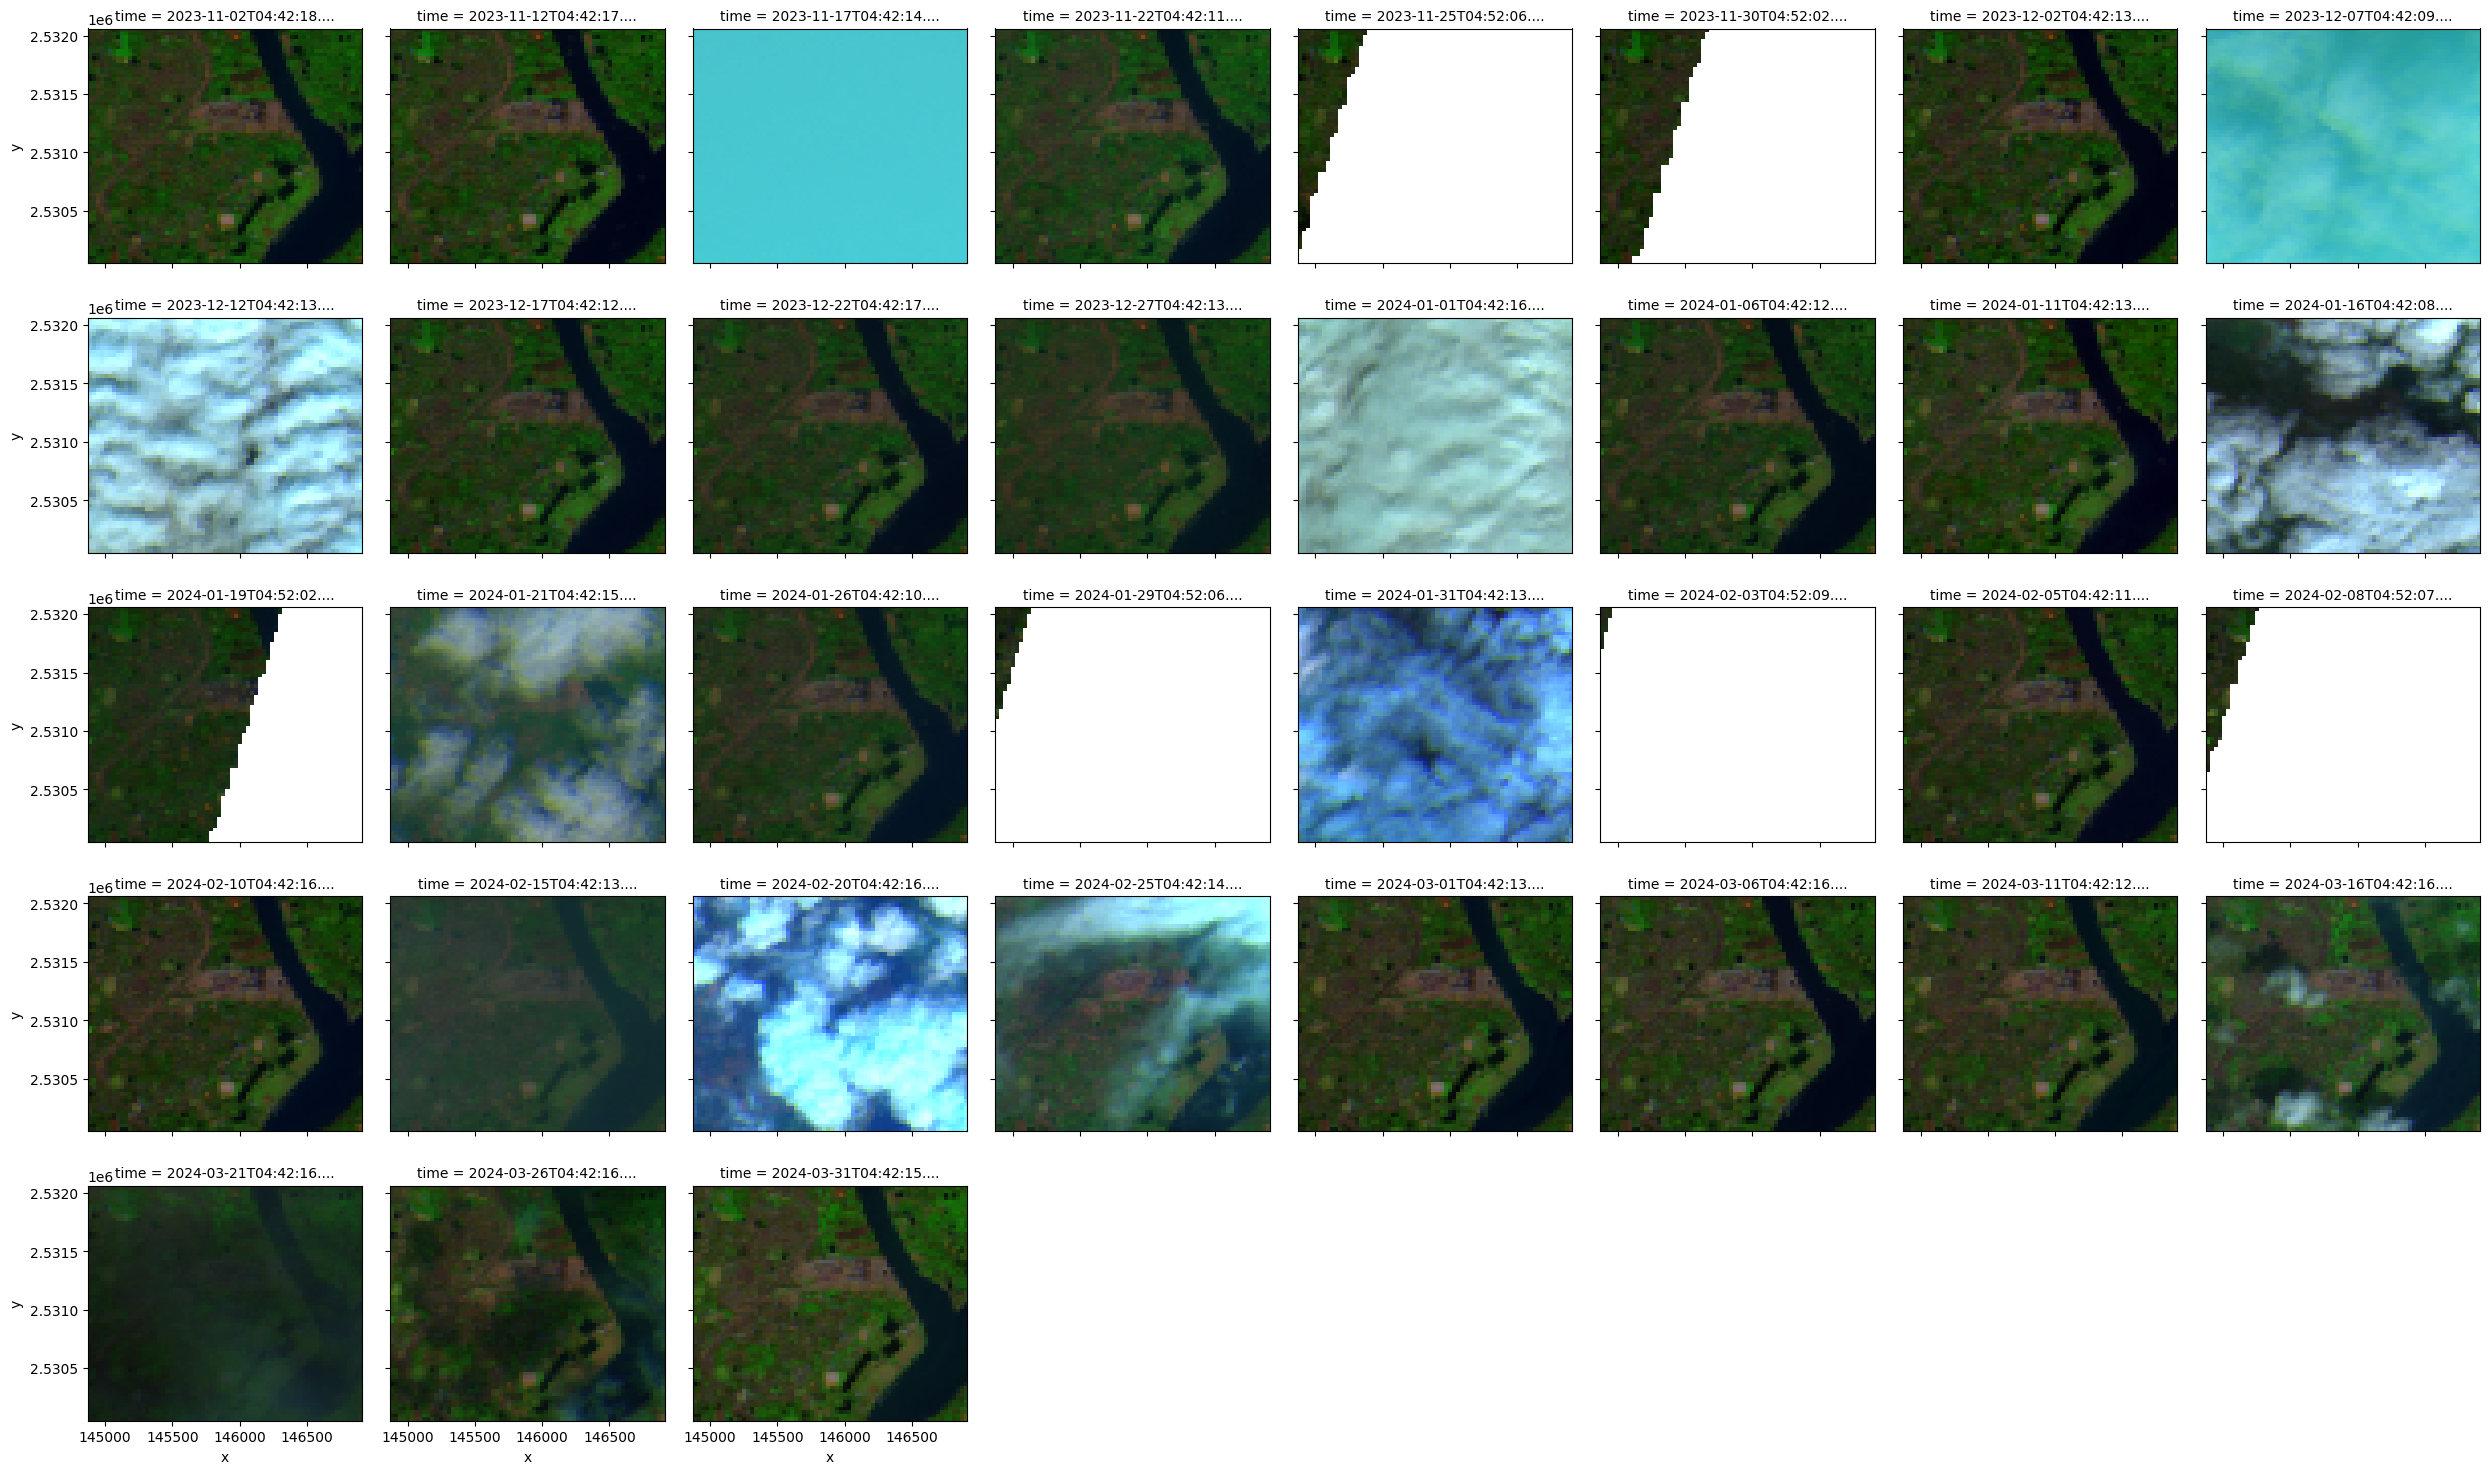

In [12]:
# Checking results
size=3
col_wrap = np.minimum(len(ds.time),8)

# Plotting

ds[['swir22', 'nir08', 'red']].to_array().plot.imshow(col='time', col_wrap=col_wrap, vmin=0, vmax=1, size=size)  # false colour
plt.show()

# Cloud masking
## Clear pixel mask

Based on the pixel quality flag (`scl` in the current dataset), we can also derive a mask of clear observations for each time slice, identifying those pixels not affected by clouds, cloud shadows, etc. Because such phenomena simultaneously affect all bands in the dataset, there will only be one such mask per time slice (for all measurements).

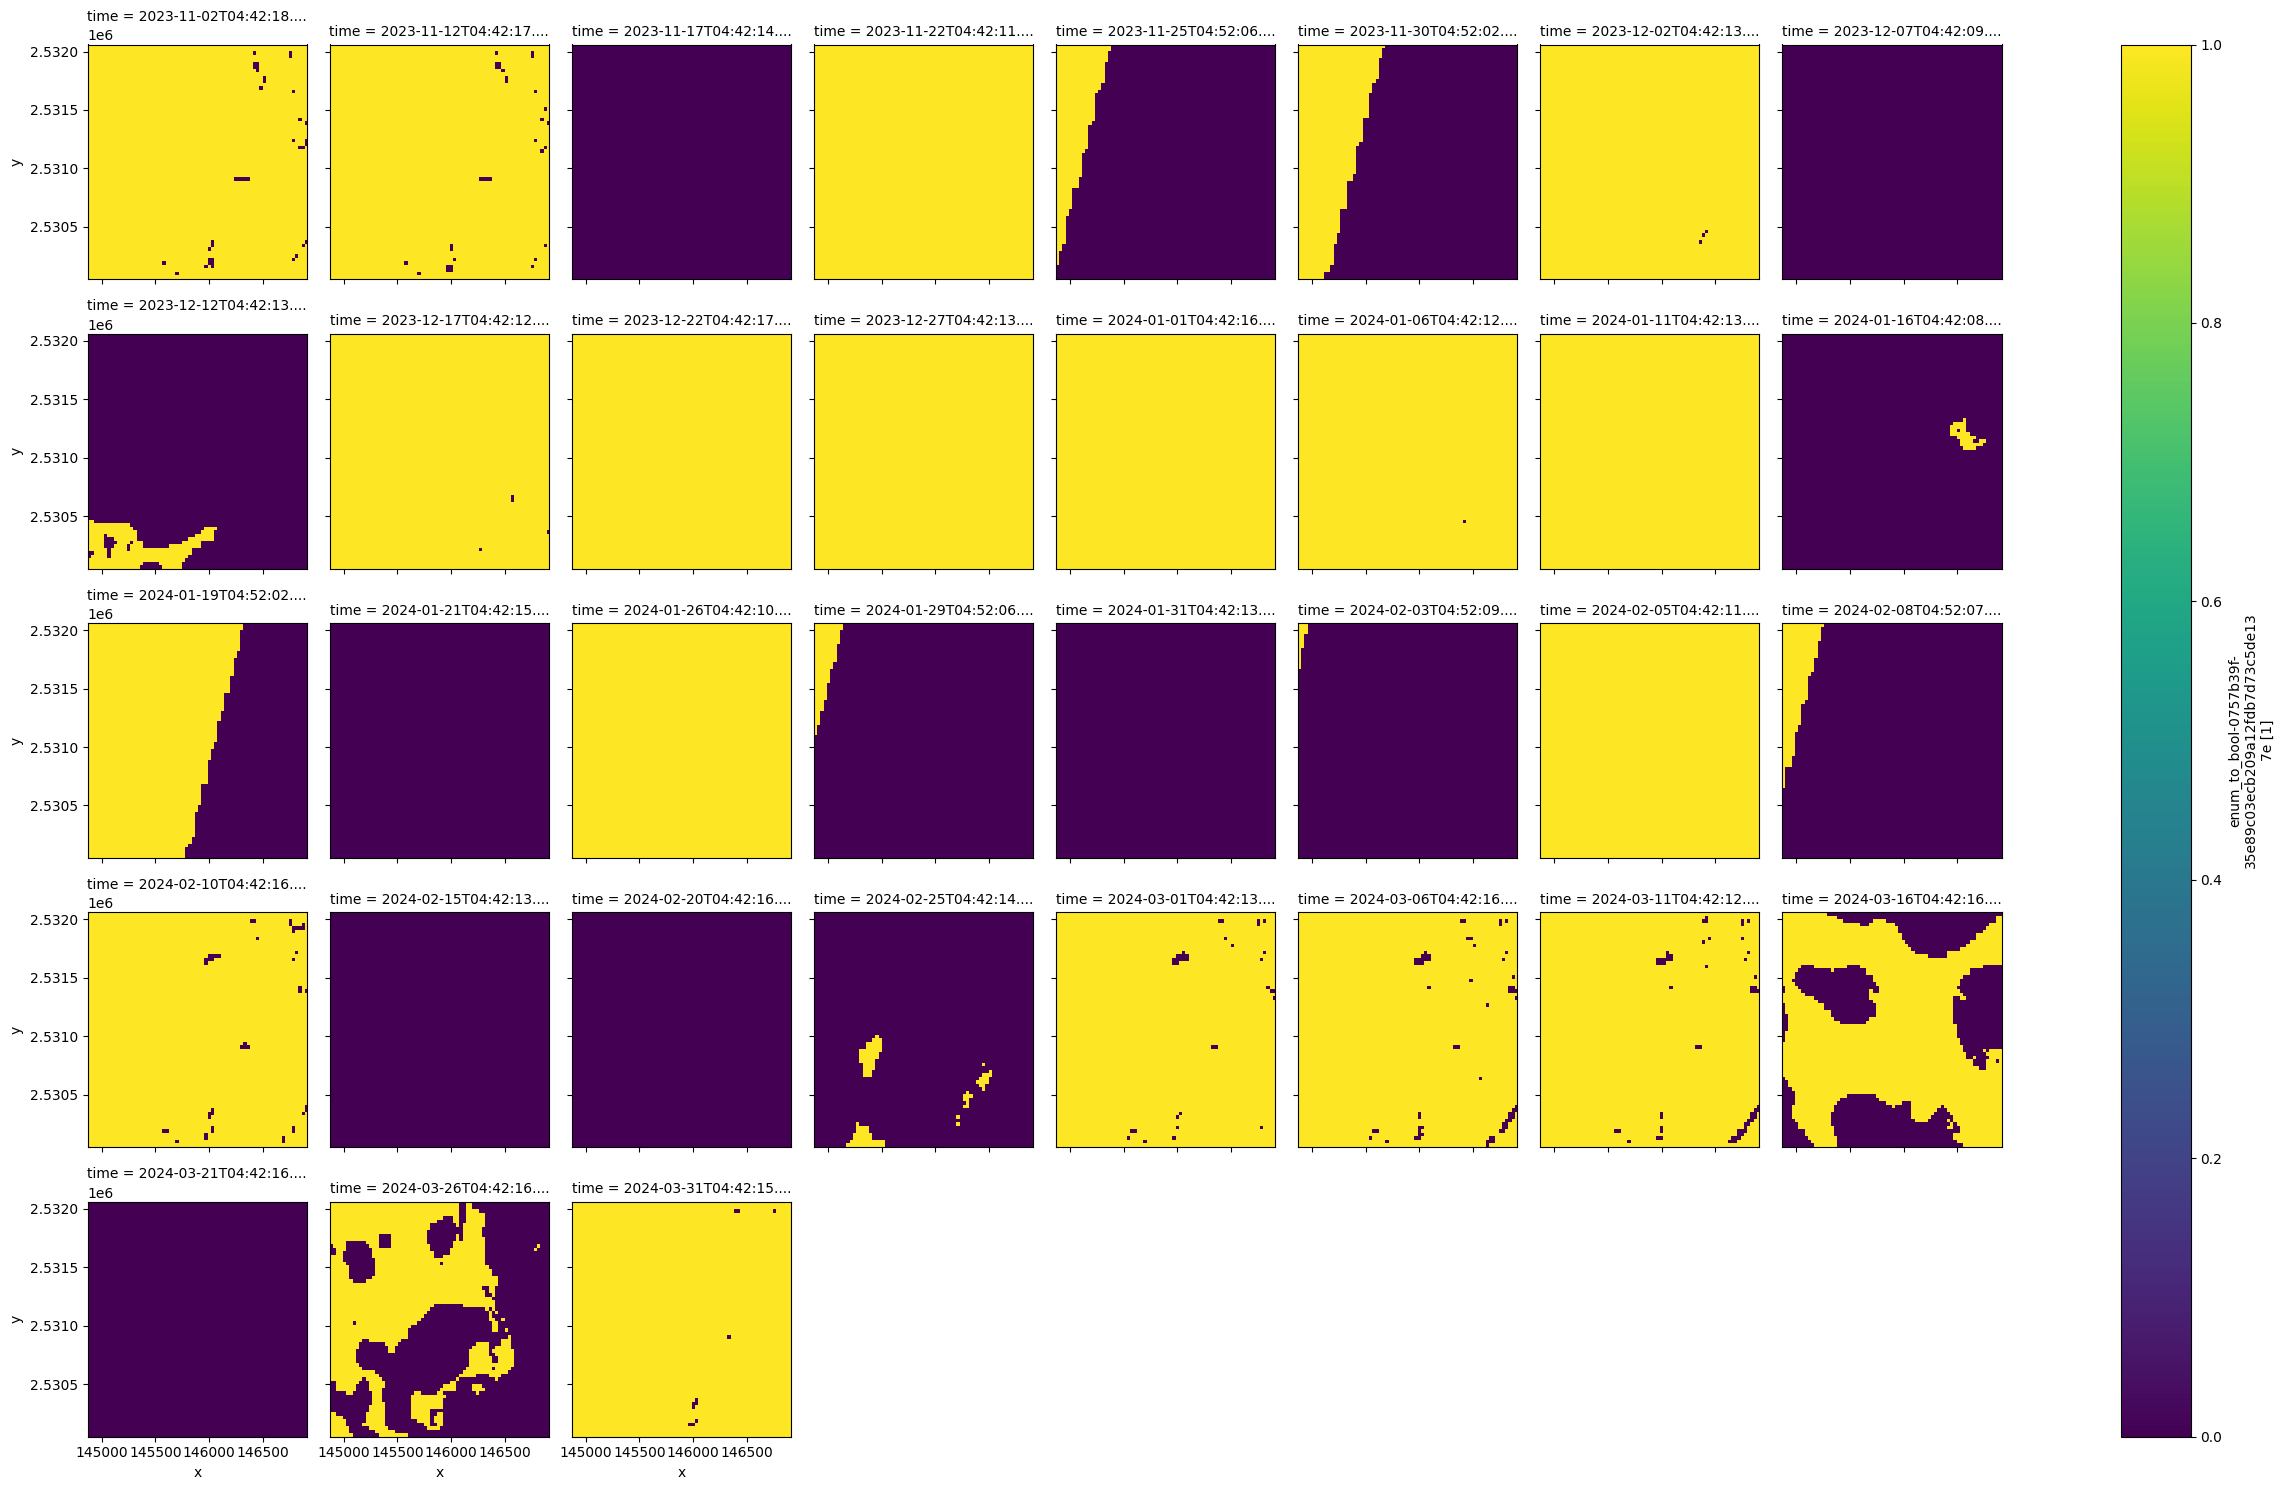

In [13]:
# Mask of clear pixels and check
good_pixel_flags = {'water', 'vegetation', 'bare soils'}   # pixels to retain (i.e. remove pixels flagged as 'nodata', 'cloud', 'shadow')
good_pixel_mask = enum_to_bool(ds['SCL'], good_pixel_flags)
good_pixel_mask = good_pixel_mask.persist()

good_pixel_mask.plot.imshow(col='time', col_wrap=col_wrap, size=size)  # binary maps
plt.show()

## Valid pixel mask

First, we can create a mask layer to identify the `nodata` pixels, i.e. invalid pixels. This mask can be used to keep only those pixels corresponding to valid data, which will here correspond to clear observations, as well as clouds, shadows, etc.

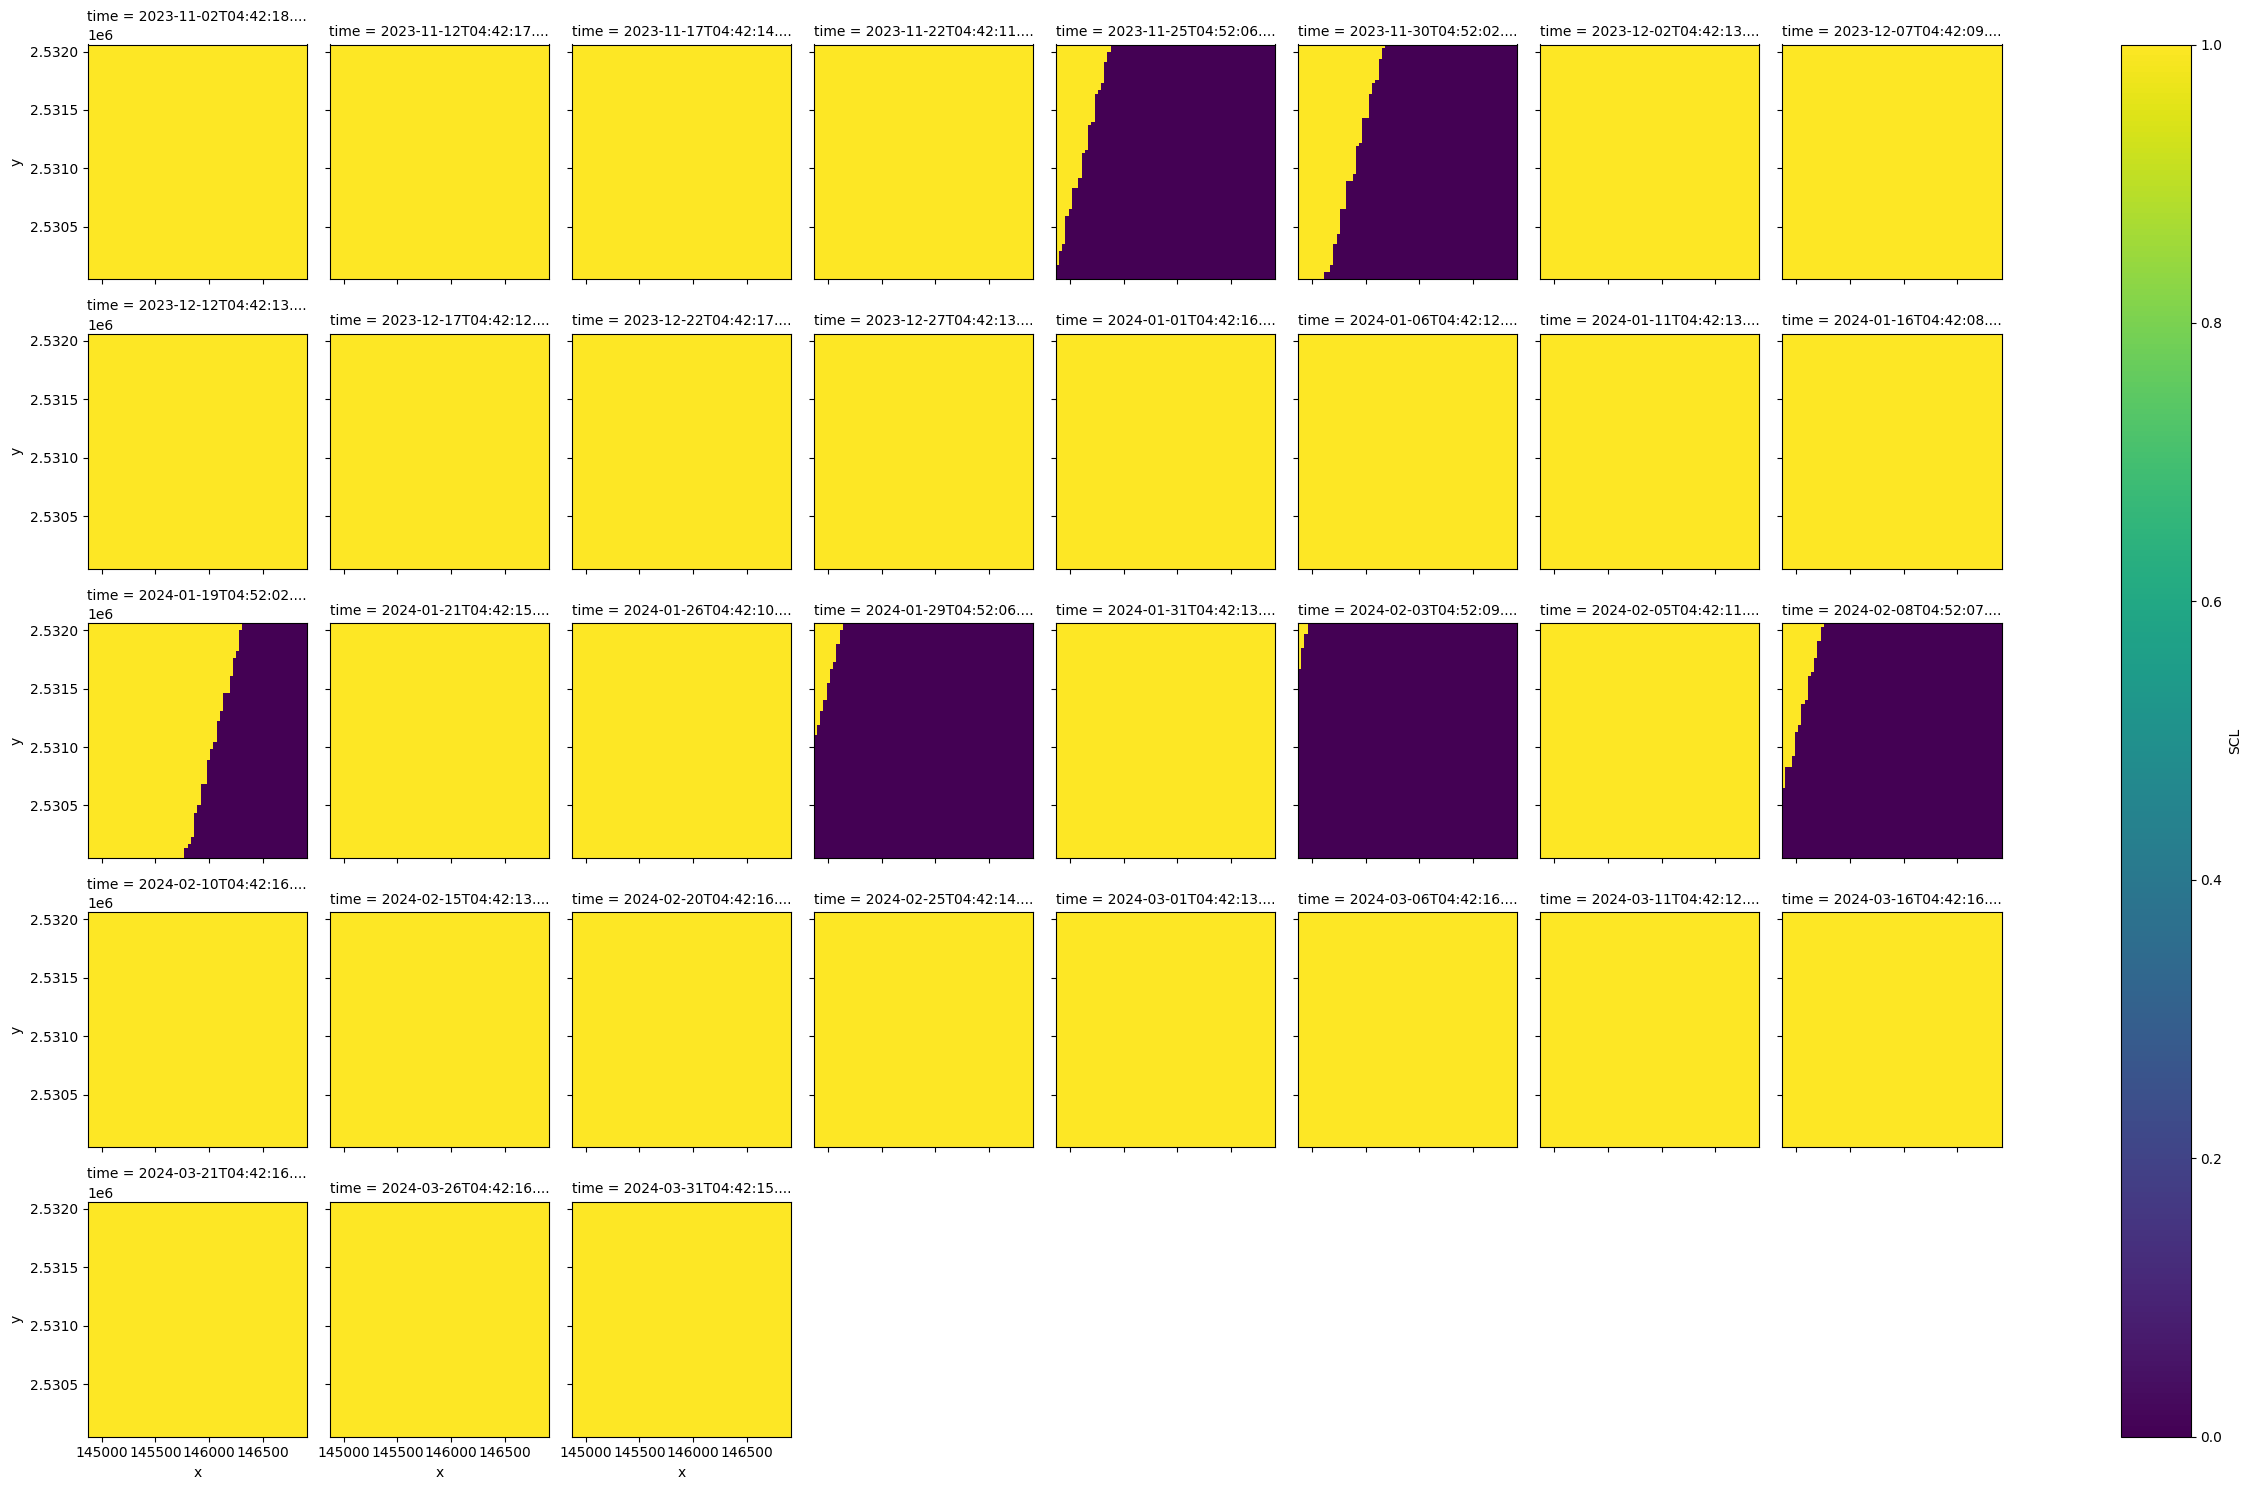

In [14]:
# Mask of valid data (i.e. not 'nodata') and check

data_valid_mask = masking.valid_data_mask(ds)
data_valid_mask = data_valid_mask.persist()

valid_mask = data_valid_mask['SCL']
valid_mask = valid_mask.persist()

valid_mask.plot(col='time', col_wrap=8)
plt.show()

## Cloud masking and checking

We apply the cloud mask to the refelectance bands in the dataset `ds` and the when visualise.

In [15]:
# Masking clouds
sr_bands = ["blue", "green", "red", "nir08", "swir16", "swir22"]

for band in sr_bands:
    ds[band] = ds[band].where(valid_mask & good_pixel_mask)

ds

<xarray.Dataset> Size: 4MB
Dimensions:      (time: 35, y: 67, x: 68)
Coordinates:
  * time         (time) datetime64[ns] 280B 2023-11-02T04:42:18.657000 ... 20...
  * y            (y) float64 536B 2.532e+06 2.532e+06 ... 2.53e+06 2.53e+06
  * x            (x) float64 544B 1.449e+05 1.449e+05 ... 1.469e+05 1.469e+05
    spatial_ref  int32 4B 32646
Data variables:
    blue         (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    green        (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    red          (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    nir08        (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    swir16       (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    swir22       (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    SCL          (time, y, x) uint8 159kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
Attributes:
    crs:           EPSG:32646
    grid_mapping:  spatial_ref

/env/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


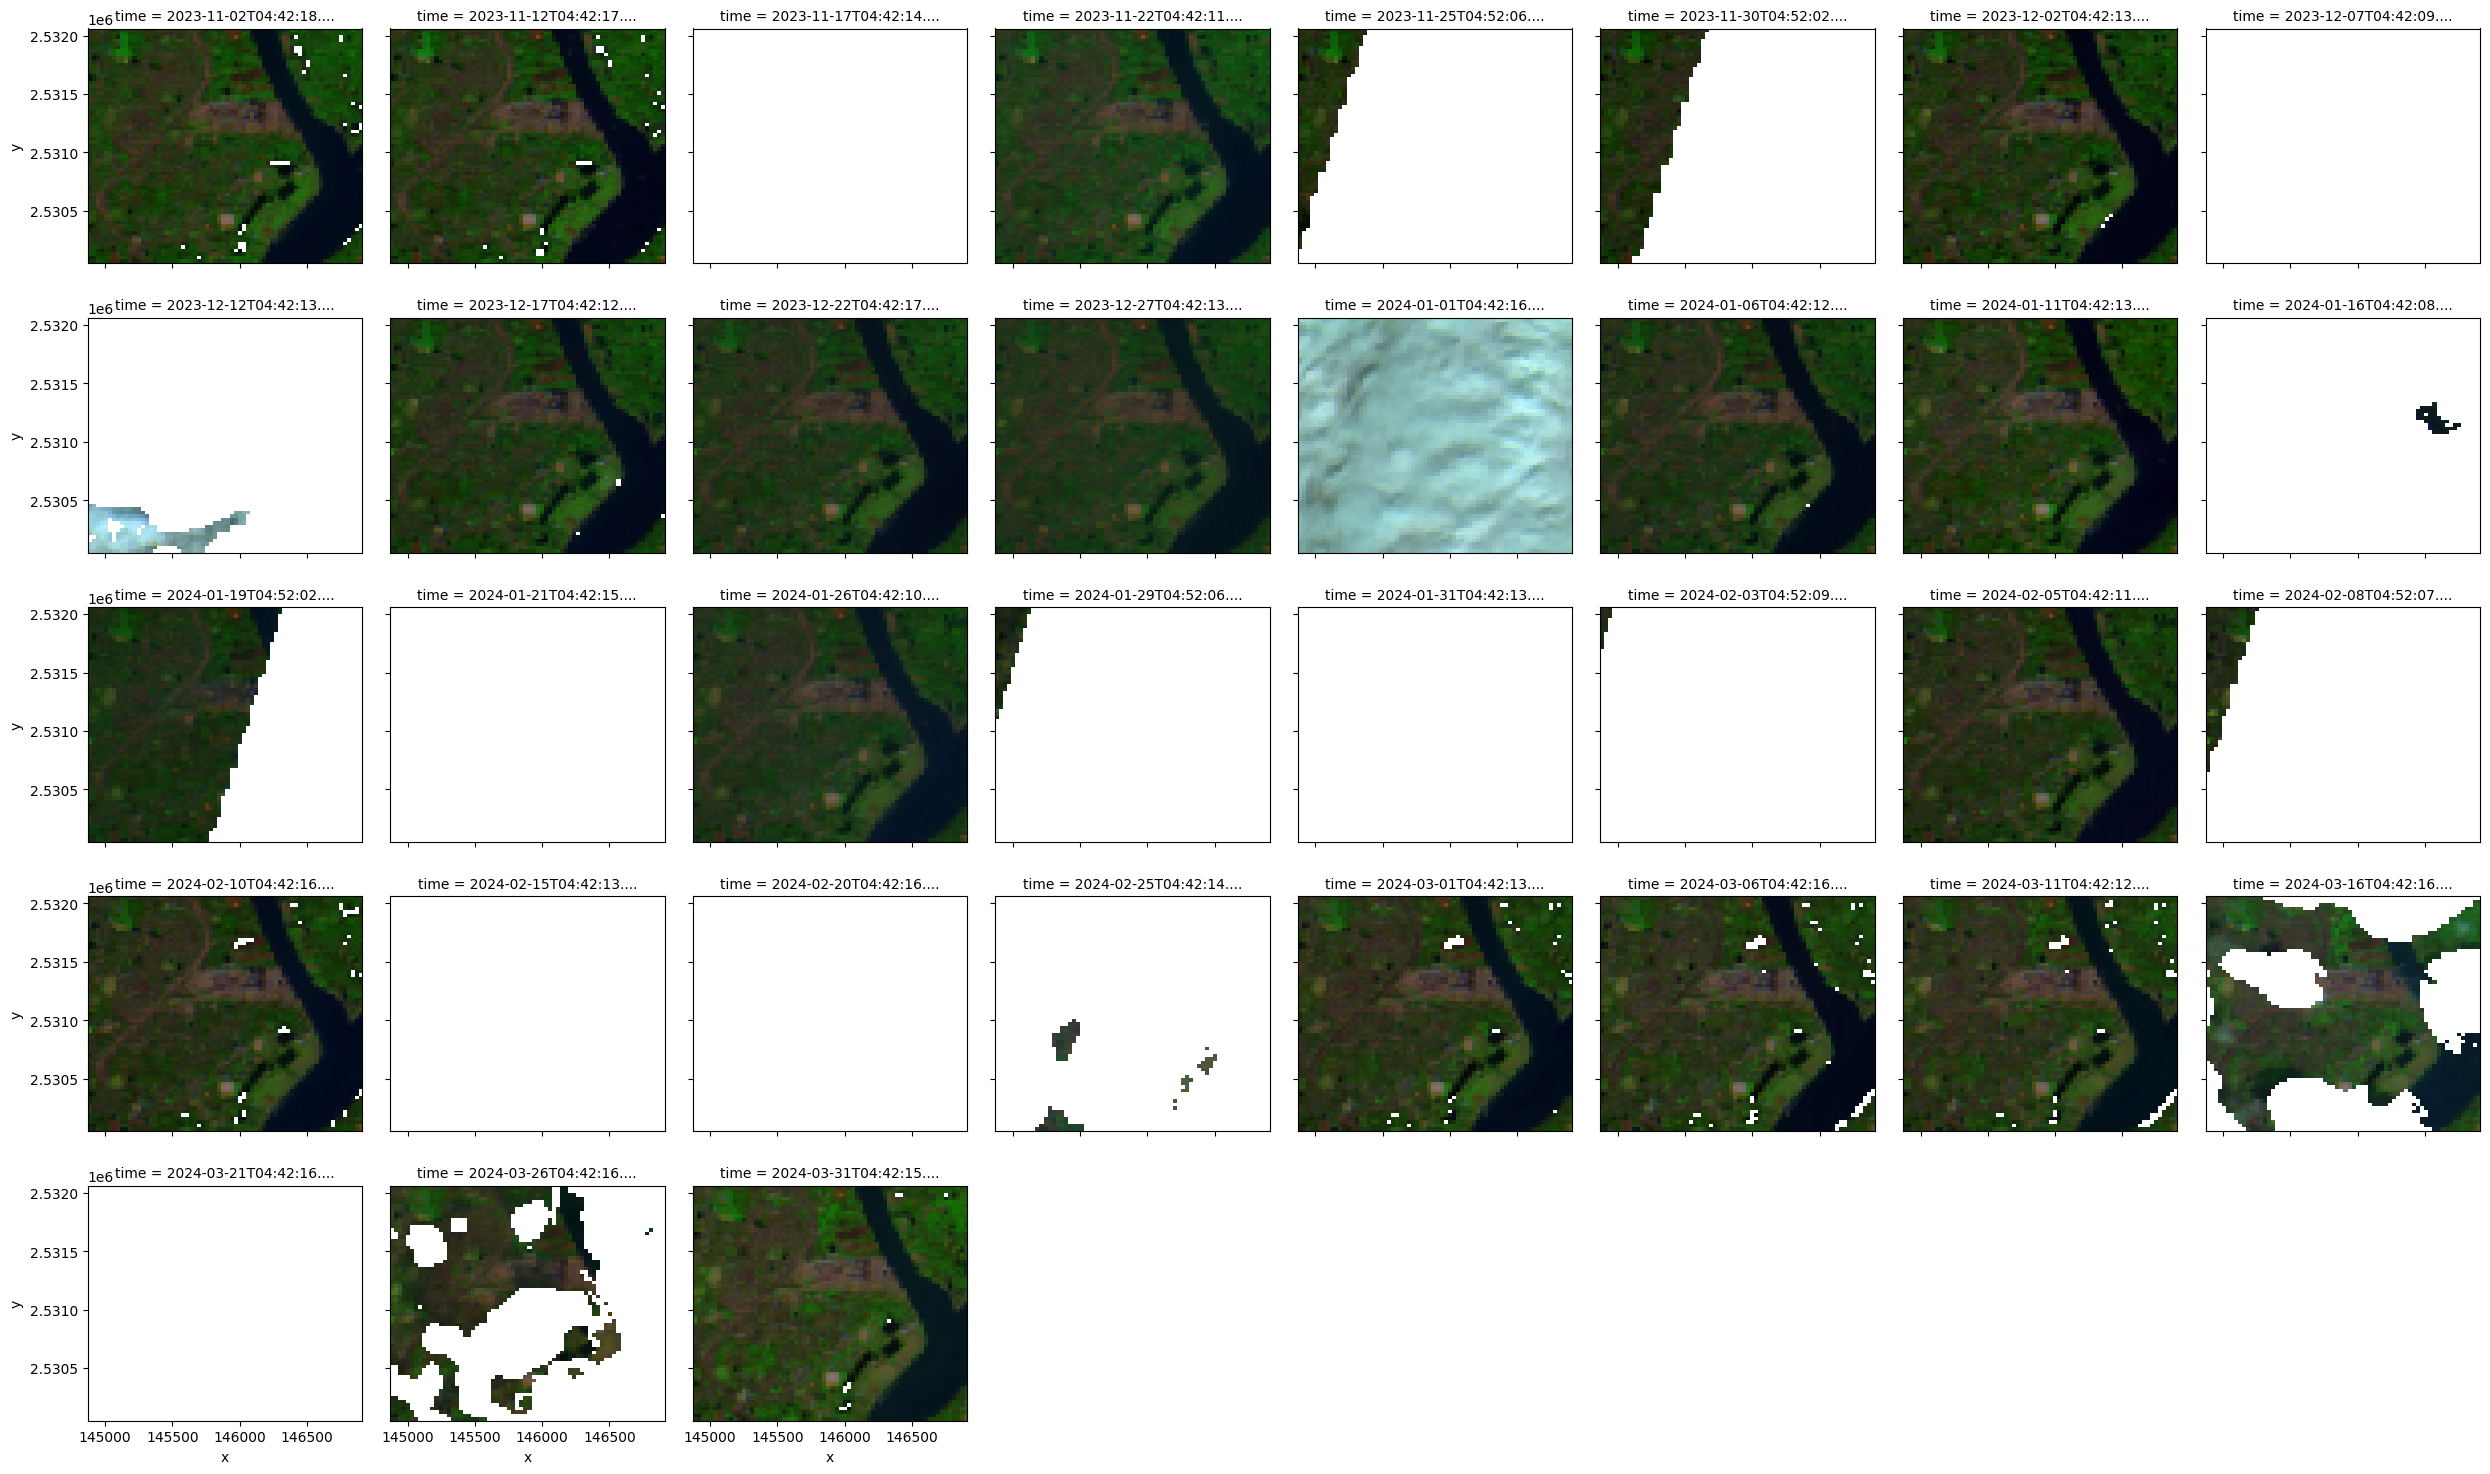

In [16]:
# Plotting the masked dataset

ds[['swir22', 'nir08', 'red']].to_array().plot.imshow(col='time', col_wrap=col_wrap, vmin=0, vmax=1, size=size)  # false colour
plt.show()

We can see that most images have been masked correctly, but there is one image on 2024-01-01 that still has cloud cover over almost the entire image, we can check the `SCL` using Holoviews to produce an interactive plot of these data.

In [17]:
# Make SCL image
# https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
# https://www.sentinel-hub.com/faq/how-get-s2a-scene-classification-sentinel-2/

from bokeh.models.tickers import FixedTicker

color_def = [
    (0,  '#000000', 'No data'),   # black
    (1,  '#ff0004', 'Saturated or defective'),   # red
    (2,  '#868686', 'Topographic and casted shadow'),   # gray
    (3,  '#774c0b', 'Cloud shadows'),   # brown
    (4,  '#10d32d', 'Vegetation'),   # green
    (5,  '#ffff53', 'Not vegetated'),   # yellow
    (6,  '#0000ff', 'Water'),   # blue
    (7,  '#818181', 'Unclassified'),   # medium gray
    (8,  '#c0c0c0', 'Cloud medium probability'),   # light gray
    (9,  '#f2f2f2', 'Cloud high probability'),   # very light gray
    (10, '#bbc5ec', 'Thin cirrus'),   # light blue/purple
    (11, '#53fff9', 'Snow or ice'),   # cyan
]
color_val = [x[0] for x in color_def]
color_hex = [x[1] for x in color_def]
color_txt = [f'{x[0]:2d}: {x[2]}' for x in color_def]
color_lim = (min(color_val), max(color_val) + 1)
bin_edges = color_val + [max(color_val) + 1]
bin_range = (color_val[0] + 0.5, color_val[-1] + 0.5)  # No idea why (0.5,11.5) works and (0,11) or (0,12) do not

# These options manipulate the color map and colorbar to show the categories for this product
options = {
    'title': f'Flag data for: {query["product"]} ({'SCL'})',
    'cmap': color_hex,
    'clim': color_lim,
    'color_levels': bin_edges,
    'colorbar': True,
    'width': 800,
    'height': 450,
    'aspect': 'equal',
    'tools': ['hover'],
    'colorbar_opts': {
        'major_label_overrides': dict(zip(color_val, color_txt)),
        'major_label_text_align': 'left',
        'ticker': FixedTicker(ticks=color_val),
    },
}

# Set the Dataset CRS
plot_crs = dst_crs
if plot_crs == 'epsg:4326':
    plot_crs = ccrs.PlateCarree()


# Native data and coastline overlay:
# - Comment `crs`, `projection`, `coastline` to plot in native_crs coords
# TODO: Update the axis labels to 'longitude', 'latitude' if `coastline` is used

quality_plot = ds['SCL'].hvplot.image(
    x = 'x', y = 'y',                        # Dataset x,y dimension names
    rasterize = True,                        # Use Datashader
    aggregator = reductions.mode(),          # Datashader selects mode value, requires 'hv.Image'
    precompute = True,                       # Datashader precomputes what it can
    # crs = plot_crs,                          # Datset crs
    # projection = ccrs.PlateCarree(),         # Output projection (ccrs.PlateCarree() when coastline=True)
    # coastline = '10m',                       # Coastline = '10m'/'50m'/'110m'
).options(opts.Image(**options)).hist(bin_range = bin_range)

# display(quality_plot)
# Optional: Change the default time slider to a dropdown list, https://stackoverflow.com/a/54912917
fig = pn.panel(quality_plot, widgets={'time': pn.widgets.Select})  # widget_location='top_left'
fig

Row
    [0] HoloViews(AdjointLayout, widgets={'time': <class '...})
    [1] WidgetBox(align=('end', 'start'))
        [0] Select(name='time (seconds s..., options={'2023-11-02 04:42:18': nu...}, value=numpy.datetime64('2023-11-...)

It can be seen that `SCL` missclassifies the data for 2024-01-01 therefore we will try and apply a `score_mask` based on reflectance properties of the image  (see Schmitt et al., 2019, https://doi.org/10.5194/isprs-annals-IV-2-W7-145-2019 for details).

In [18]:
def score_mask(ds):
    """
    Applies a cloud score mask based on blue, red, green, NIR, and SWIR bands.

    Parameters:
    ds (xarray.Dataset): An xarray dataset containing bands blue, green, red, nir08, swir16, and swir22.

    Returns:
    xarray.Dataset: The dataset with a cloud mask applied.
    """

    # Normalize bands
    blue = ds["blue"]
    green = ds["green"]
    red = ds["red"]
    nir = ds["nir08"]
    swir1 = ds["swir16"]
    swir2 = ds["swir22"]

    # Compute cloud scores
    blue_score = (blue - 0.1) / 0.2
    rgb_score = ((red + green + blue) - 0.2) / 0.6
    ir_score = ((nir + swir1 + swir2) - 0.3) / 0.5
    
    # Compute NDSI
    ndsi = (green - swir1) / (green + swir1)
    ndsi_score = (ndsi - 0.8) / -0.2
    
    # Compute final cloud score (taking minimum of all scores)
    score = np.minimum.reduce([blue_score, rgb_score, ir_score, ndsi_score])
    
    # Mask out pixels with a cloud score above 0.6
    cloud_mask = score <= 0.6
    ds = ds.where(cloud_mask)

    return ds


In [19]:
ds_masked = score_mask(ds)
ds_masked

<xarray.Dataset> Size: 4MB
Dimensions:      (time: 35, y: 67, x: 68)
Coordinates:
  * time         (time) datetime64[ns] 280B 2023-11-02T04:42:18.657000 ... 20...
  * y            (y) float64 536B 2.532e+06 2.532e+06 ... 2.53e+06 2.53e+06
  * x            (x) float64 544B 1.449e+05 1.449e+05 ... 1.469e+05 1.469e+05
    spatial_ref  int32 4B 32646
Data variables:
    blue         (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    green        (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    red          (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    nir08        (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    swir16       (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    swir22       (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
    SCL          (time, y, x) float32 638kB dask.array<chunksize=(10, 67, 68), meta=np.ndarray>
Attributes:
    crs:           EPSG:32646
    grid_mapping:  spatial_ref

/env/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


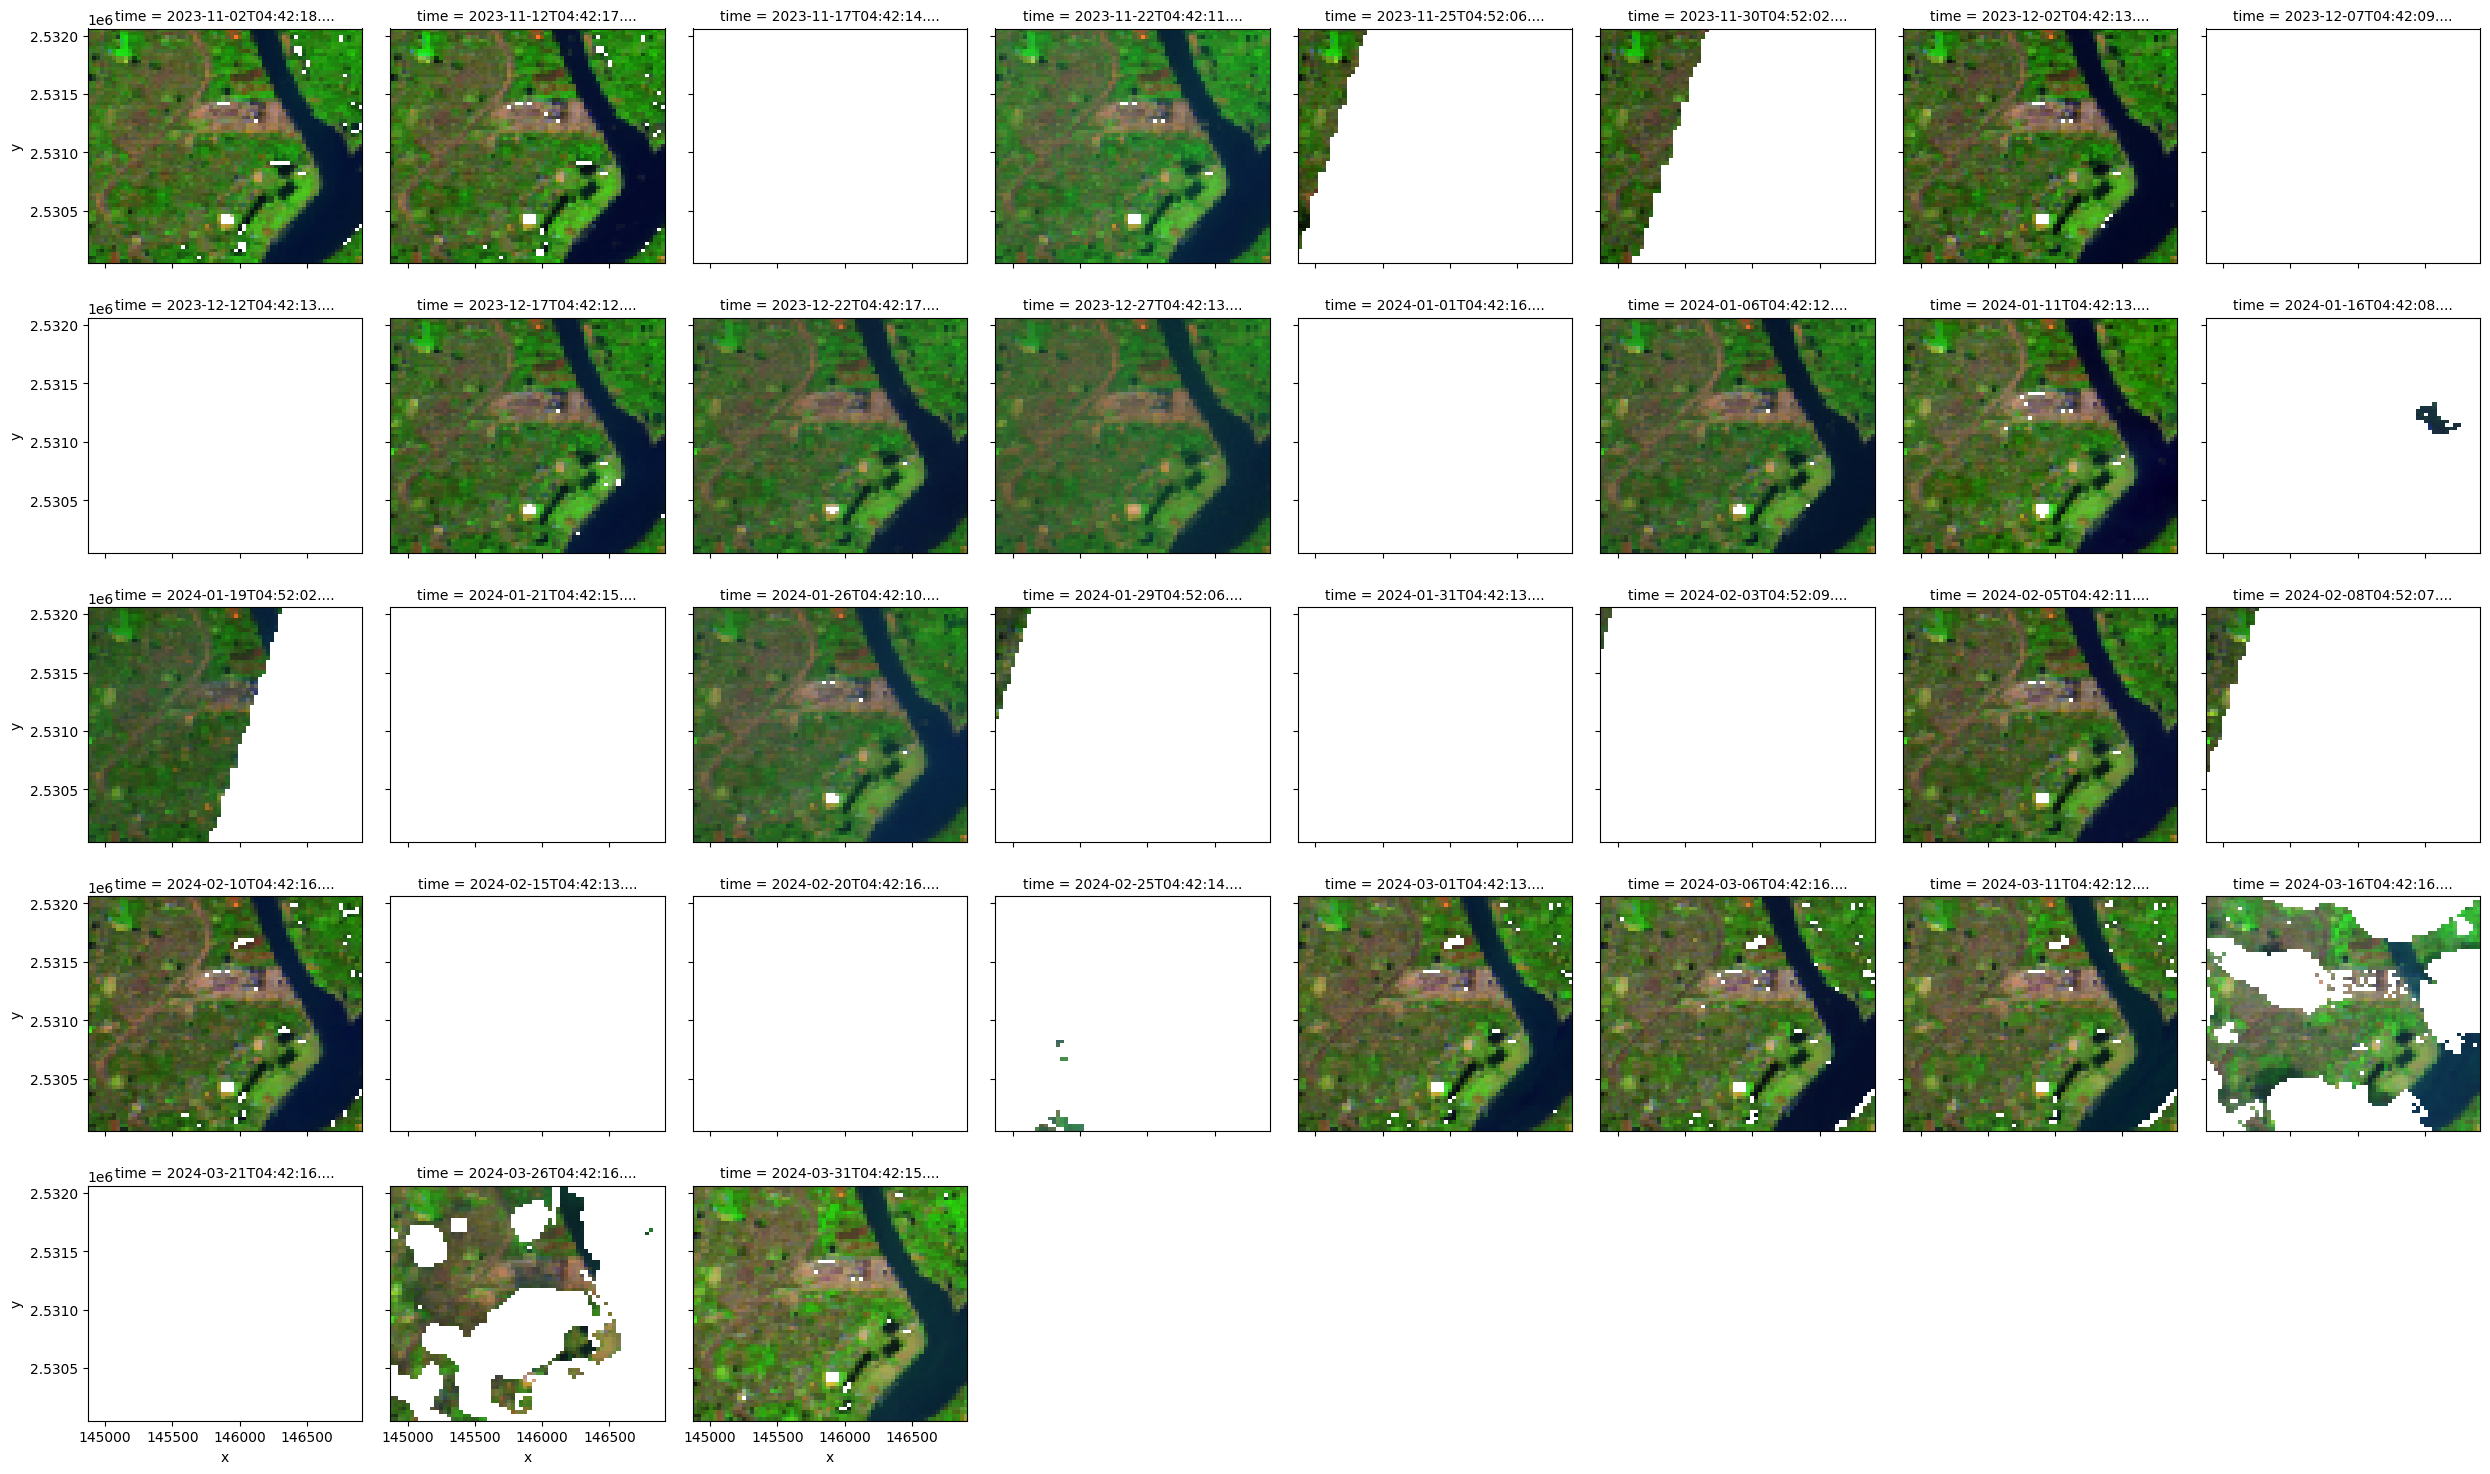

In [20]:
# Plotting the masked dataset

ds_masked[['swir22', 'nir08', 'red']].to_array().plot.imshow(col='time', col_wrap=col_wrap, vmin=0, vmax=1, size=size)  # false colour
plt.show()

The cloud score mask has succesfully masked the problematic image. Now we will create a function that performs all the above pre-processing in one go, so we can use it later to produce (mostly) cloud-free images.

# Creating a load ARD Sentinel-2 function



In [21]:
def load_s2_reflectance(date_init, date_end, ul_coord, lr_coord, crs, dask_chunks):
    lat_north = ul_coord[0]
    lat_south = lr_coord[0]
    lon_west = ul_coord[1]
    lon_east = lr_coord[1]

    dc = datacube.Datacube()

    query = {
        "time": (date_init, date_end),
        "x": (lon_west, lon_east),
        "y": (lat_north, lat_south),
        "product": 's2_l2a',
        "measurements": ["blue",
                         "green",
                         "red",
                         "nir08",
                         "swir16",
                         "swir22",
                         "SCL"],
        "resolution": (-30, 30),
        # "resolution": (-500, 500),
        "crs": crs,
        "output_crs": crs,
        "dask_chunks": dask_chunks,
        "group_by": "solar_day",
        # 'resampling': 'bilinear'

    }
    print(query)
    start = time.process_time()
    ds = dc.load(skip_broken_datasets=True, **query)

    min_gooddata = 0.2   # percentage threshold

    # Mask of valid pixels
    good_pixel_flags = {'water', 'vegetation', 'bare soils'}   # pixels to retain (i.e. remove pixels flagged as 'nodata', 'cloud', 'shadow')
    good_pixel_mask = enum_to_bool(ds['SCL'], good_pixel_flags)
    good_pixel_mask = good_pixel_mask.persist()

    # Percentage of good data for each time slice
    data_perc = good_pixel_mask.sum(axis=[1, 2]) / (good_pixel_mask.shape[1]*good_pixel_mask.shape[2])
    keep = (data_perc >= min_gooddata).persist()

    # Drop low quality time slices
    total_obs = len(ds.time)
    ds = ds.sel(time=keep)
    good_pixel_mask = good_pixel_mask.sel(time=keep)

    print(f'Filtered the time series to {len(ds.time)} (out of {total_obs}) '
          f'time steps with at least {min_gooddata:.1%} good quality pixels.')

    
    # Valid (not 'no-data') masks, for all bands
    data_valid_mask = masking.valid_data_mask(ds)
    data_valid_mask = data_valid_mask.persist()

    valid_mask = data_valid_mask['SCL']
    valid_mask = valid_mask.persist()

    # Scaling factors for Sentinel-2 data
    scale = 0.0001  # divide by 1000
    offset = 0.0  # Use this one instead of the one in the prodcut description 

    # Apply valid mask, good pixel mask, and scaling to each layer
    ds = to_f32(ds)

    # Masking clouds
    sr_bands = ["blue", "green", "red", "nir08", "swir16", "swir22"]

    for band in sr_bands:
        ds[band] = ds[band].where(valid_mask & good_pixel_mask)  * scale + offset

    # Compute cloud scores
    blue_score = (ds['blue'] - 0.1) / 0.2
    rgb_score = ((ds['red'] + ds['green'] + ds['blue']) - 0.2) / 0.6
    ir_score = ((ds['nir08'] + ds['swir16'] + ds['swir22']) - 0.3) / 0.5
    
    # Compute NDSI
    ndsi = (ds['green'] - ds['swir16']) / (ds['green'] + ds['swir16'])
    ndsi_score = (ndsi - 0.8) / -0.2
    
    # Compute final cloud score (taking minimum of all scores)
    score = np.minimum.reduce([blue_score, rgb_score, ir_score, ndsi_score])
    
    # Mask out pixels with a cloud score above 0.6
    cloud_mask = score <= 0.6
    ds = ds.where(cloud_mask)

    ds = ds.persist()  # Note that this will *START* the persist process. Look at your Dask cluster to monitor the load progress.
    print(time.process_time() - start, ' seconds for load_s2_reflectance')
    return ds


In [22]:
S2 = load_s2_reflectance(date_init, date_end, ul_coord, lr_coord, dst_crs, dask_chunks)
S2

{'time': ('2023-11-01', '2024-03-31'), 'x': (144898.7960046347, 146898.7960046347), 'y': (2532058.2251166785, 2530058.2251166785), 'product': 's2_l2a', 'measurements': ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'SCL'], 'resolution': (-30, 30), 'crs': 'EPSG:32646', 'output_crs': 'EPSG:32646', 'dask_chunks': {'time': 10, 'x': 100, 'y': 100}, 'group_by': 'solar_day'}
Filtered the time series to 21 (out of 35) time steps with at least 20.0% good quality pixels.
0.45366860700000444  seconds for load_s2_reflectance


<xarray.Dataset> Size: 3MB
Dimensions:      (time: 21, y: 67, x: 68)
Coordinates:
  * time         (time) datetime64[ns] 168B 2023-11-02T04:42:18.657000 ... 20...
  * y            (y) float64 536B 2.532e+06 2.532e+06 ... 2.53e+06 2.53e+06
  * x            (x) float64 544B 1.449e+05 1.449e+05 ... 1.469e+05 1.469e+05
    spatial_ref  int32 4B 32646
Data variables:
    blue         (time, y, x) float32 383kB dask.array<chunksize=(6, 67, 68), meta=np.ndarray>
    green        (time, y, x) float32 383kB dask.array<chunksize=(6, 67, 68), meta=np.ndarray>
    red          (time, y, x) float32 383kB dask.array<chunksize=(6, 67, 68), meta=np.ndarray>
    nir08        (time, y, x) float32 383kB dask.array<chunksize=(6, 67, 68), meta=np.ndarray>
    swir16       (time, y, x) float32 383kB dask.array<chunksize=(6, 67, 68), meta=np.ndarray>
    swir22       (time, y, x) float32 383kB dask.array<chunksize=(6, 67, 68), meta=np.ndarray>
    SCL          (time, y, x) float32 383kB dask.array<chunksize=(6, 67, 68), meta=np.ndarray>
Attributes:
    crs:           EPSG:32646
    grid_mapping:  spatial_ref

In [23]:
# Checking results
size=3
col_wrap = np.minimum(len(S2.time),8)
S2.red.max().compute(), S2.red.min().compute()

(<xarray.DataArray 'red' ()> Size: 4B
 array(0.30429998, dtype=float32)
 Coordinates:
     spatial_ref  int32 4B 32646,
 <xarray.DataArray 'red' ()> Size: 4B
 array(1.e-04, dtype=float32)
 Coordinates:
     spatial_ref  int32 4B 32646)

/env/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


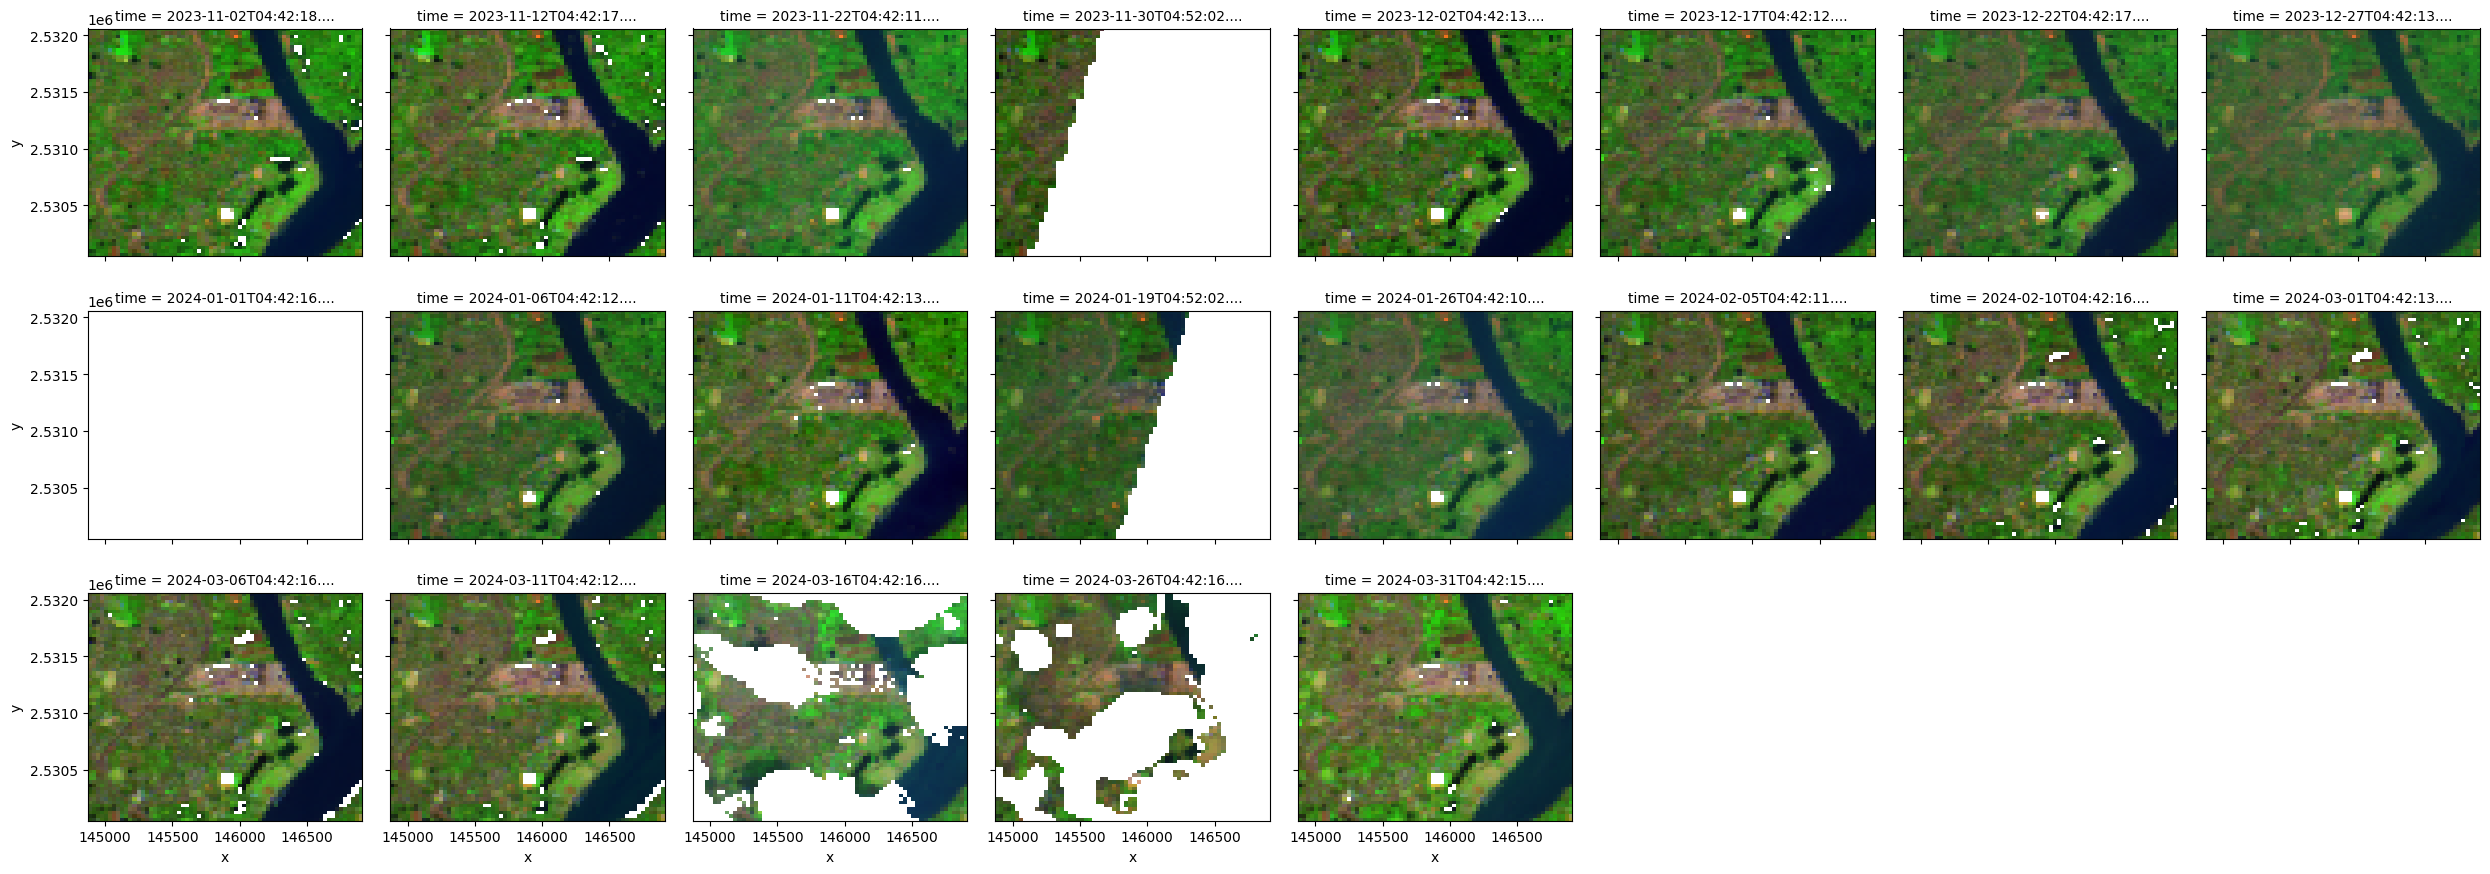

In [24]:
# Plotting

S2[['swir22', 'nir08', 'red']].to_array().plot.imshow(col='time', col_wrap=col_wrap, vmin=0, vmax=1, size=size)
plt.show()

Note that we also include a routine that only includes images that have >20% data in the dataset. Next, we compute the image, i.e., we load into memory and is not a dask arrray anymore.

In [25]:
# Computing, it can take a long time depending on the size of the array

S2 = S2.compute()
S2

<xarray.Dataset> Size: 3MB
Dimensions:      (time: 21, y: 67, x: 68)
Coordinates:
  * time         (time) datetime64[ns] 168B 2023-11-02T04:42:18.657000 ... 20...
  * y            (y) float64 536B 2.532e+06 2.532e+06 ... 2.53e+06 2.53e+06
  * x            (x) float64 544B 1.449e+05 1.449e+05 ... 1.469e+05 1.469e+05
    spatial_ref  int32 4B 32646
Data variables:
    blue         (time, y, x) float32 383kB 0.0607 0.0516 ... 0.0321 0.0792
    green        (time, y, x) float32 383kB 0.0716 0.0597 ... 0.0532 0.1086
    red          (time, y, x) float32 383kB 0.0679 0.0554 ... 0.0338 0.1123
    nir08        (time, y, x) float32 383kB 0.2187 0.2548 ... 0.272 0.3209
    swir16       (time, y, x) float32 383kB 0.1984 0.2034 ... 0.2844 0.3771
    swir22       (time, y, x) float32 383kB 0.1581 0.1488 ... 0.2348 0.3334
    SCL          (time, y, x) float32 383kB 5.0 4.0 4.0 5.0 ... 4.0 4.0 5.0 5.0
Attributes:
    crs:           EPSG:32646
    grid_mapping:  spatial_ref

# Data processing

As an example of further processing we illustarte how to resample the imagery to monthly or every 15 days.

/env/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


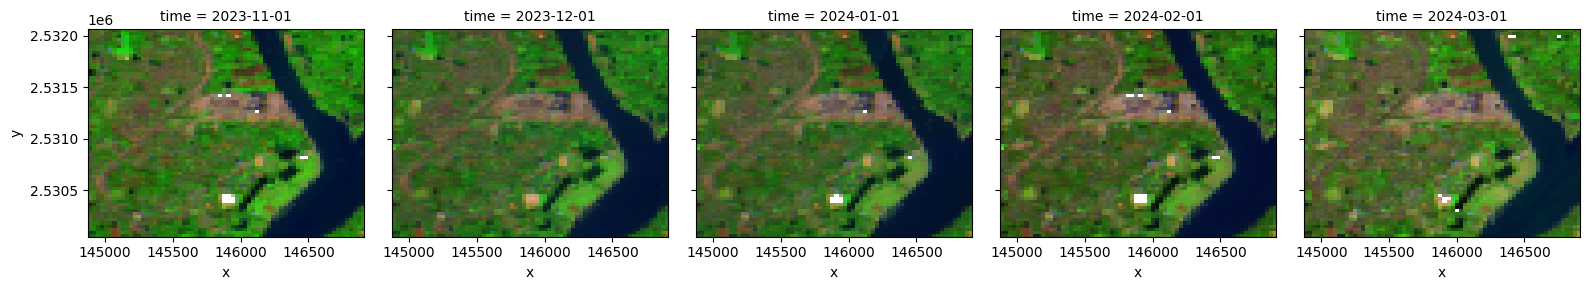

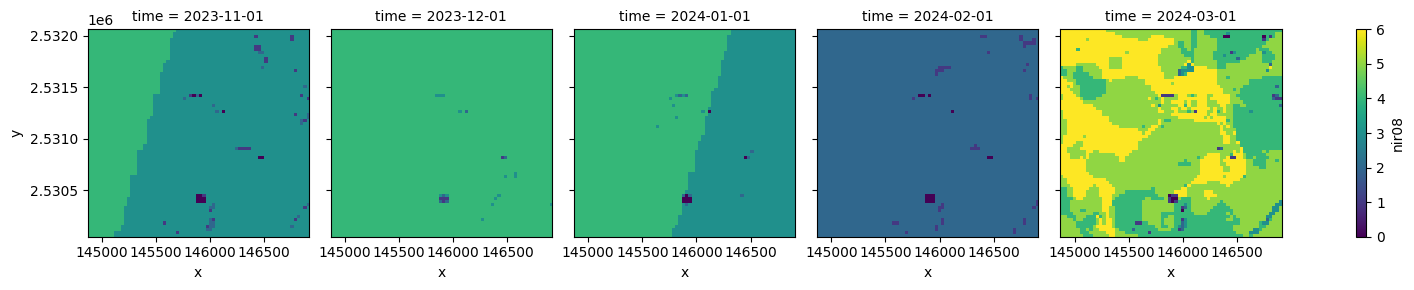

/env/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


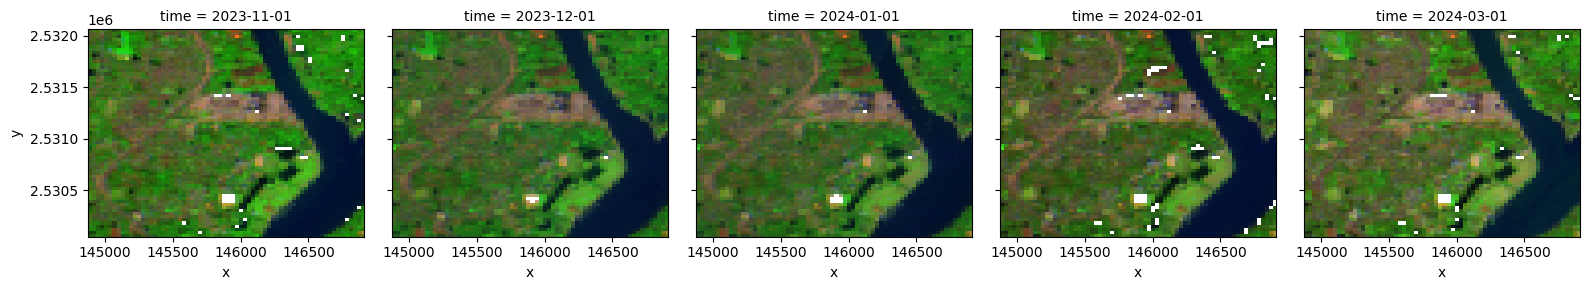

In [26]:
# Resample to one month. Also show how many obs per month. Then show again, masking anything with 1 observation only

resample_period = '1MS'

S2_res = S2.resample(time=resample_period).median(dim='time')
S2_res_n = S2['nir08'].resample(time=resample_period).count(dim='time')

size=3
col_wrap = np.minimum(len(S2_res.time),8)
S2_res[['swir22', 'nir08', 'red']].to_array().plot.imshow(col='time', col_wrap=col_wrap, vmin=0, vmax=1, size=size)
plt.show()
S2_res_n.plot.imshow(col='time', col_wrap=col_wrap, size=size)
plt.show()

S2_res[['swir22', 'nir08', 'red']].where(S2_res_n > 1).to_array().plot.imshow(col='time', col_wrap=col_wrap, vmin=0, vmax=1, size=size)
plt.show()

/env/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


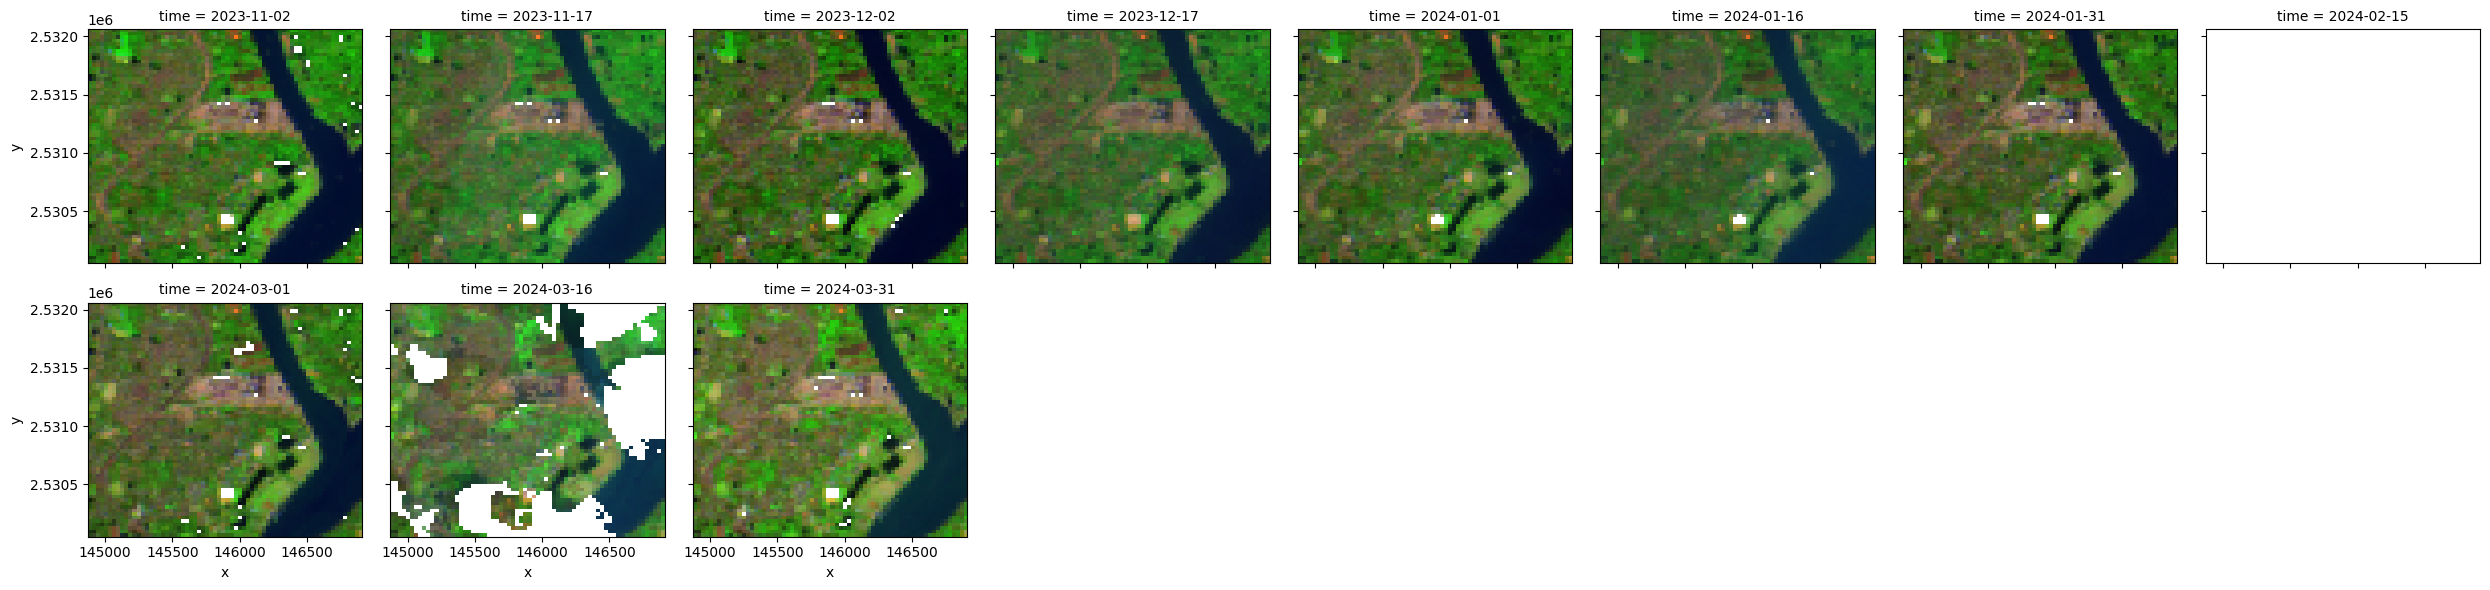

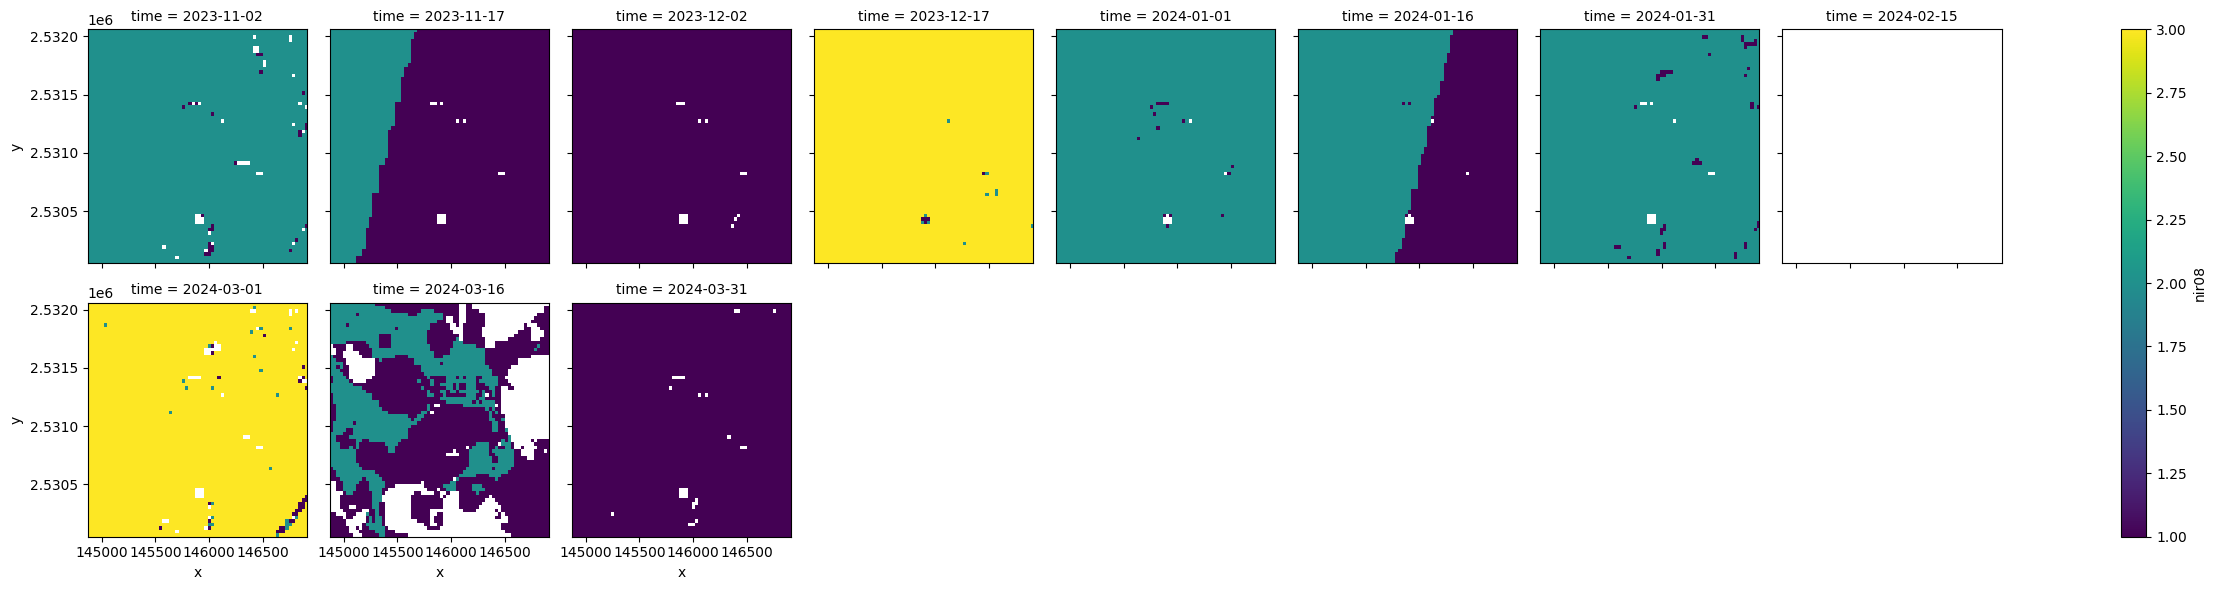

/env/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


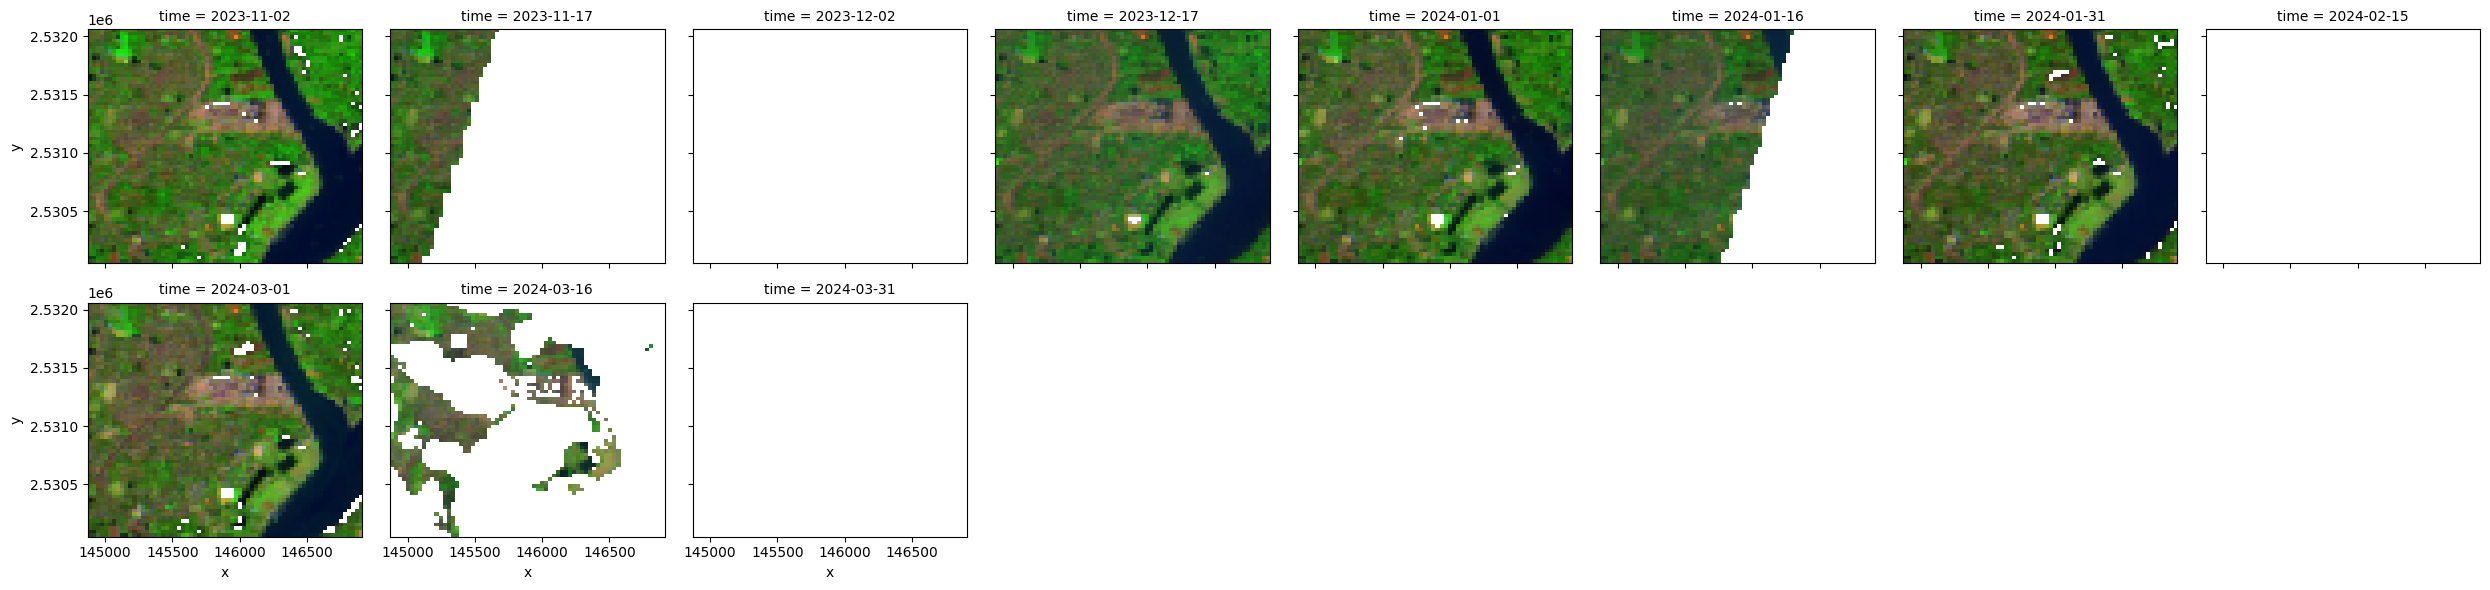

In [27]:
# Same thing, but every 15 days

resample_period = '15D'

S2_res = S2.resample(time=resample_period).median(dim='time')
S2_res_n = S2['nir08'].resample(time=resample_period).count(dim='time')

size=3
col_wrap = np.minimum(len(S2_res.time),8)
S2_res[['swir22', 'nir08', 'red']].to_array().plot.imshow(col='time', col_wrap=col_wrap, vmin=0, vmax=1, size=size)
plt.show()
S2_res_n.plot.imshow(col='time', col_wrap=col_wrap, size=size)
plt.show()

S2_res[['swir22', 'nir08', 'red']].where(S2_res_n > 1).to_array().plot.imshow(col='time', col_wrap=col_wrap, vmin=0, vmax=1, size=size)
plt.show()